In [1]:
!pip install datasets==3.5.1
!pip install latex2sympy2-extended
!pip install optuna
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 8.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 3.6.0
    Uninstalling datasets-3.6.0:
      Successfully uninstalled datasets-3.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.

In [ ]:
from datasets import load_dataset
from functools import lru_cache
from latex2sympy2_extended import latex2sympy
from mpl_toolkits.mplot3d import Axes3D
from pprint import pprint
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import make_scorer, f1_score, silhouette_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sympy import Basic
from sympy.parsing.latex import parse_latex
from transformers import AutoTokenizer, AutoModel
from typing import List, Tuple
import logging
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import random
import re
import sympy
import sympy as sp
import torch
from collections import Counter
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from collections import defaultdict
import textstat
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from lightgbm import LGBMRegressor
from scipy.special import softmax
from sklearn.preprocessing import FunctionTransformer
from sentence_transformers import SentenceTransformer
import lightgbm as lgb
from sklearn.model_selection import KFold, cross_val_score
import shap
import scipy.sparse as spa


2025-05-17 15:38:22.844534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747496303.025894      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747496303.078157      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Set random seed for reproducibility
seed = 42

# Python's built-in random module
random.seed(seed)

# NumPy
np.random.seed(seed)

# PyTorch
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Optional: Reduce verbosity

# Scikit-learn
# No explicit seed setting, but you can pass `random_state=seed` to functions like train_test_split, StratifiedKFold, etc.

# Matplotlib
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)  # Optional: Consistent colors

In [7]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("zwhe99/DeepMath-103K", num_proc=8)
train_ds = pd.DataFrame(ds['train'])

Generating train split:   0%|          | 0/103022 [00:00<?, ? examples/s]

In [ ]:
NUM_SAMPLES = 20000

In [ ]:
random_indices = random.sample(range(len(train_ds['question'])), NUM_SAMPLES if NUM_SAMPLES != float('inf') else len(train_ds['question']))

In [5]:
train_ds_qs = train_ds['question']
train_ds_tp = train_ds['topic']
train_ds_diff = train_ds['difficulty']
reason_1_ds = train_ds['r1_solution_1']
reason_2_ds = train_ds['r1_solution_2']
reason_3_ds = train_ds['r1_solution_3']
answer = train_ds['final_answer']

# Preliminary tasks

## Briefly describe the data

In [ ]:
print("Number of samples:", train_ds.num_rows)
print("Number of topics:", len(set(train_ds_tp)))
print("Number of different difficulties:", len(set(train_ds_diff)))

Number of samples: 103110
Number of topics: 82
Number of different difficulties: 20


In [ ]:
label_counts = Counter(train_ds_tp)
label_counts

Counter({'Mathematics -> Precalculus -> Limits': 7409,
         'Mathematics -> Differential Equations -> Ordinary Differential Equations (ODEs)': 1044,
         'Mathematics -> Applied Mathematics -> Statistics -> Probability -> Counting Methods -> Combinations': 1313,
         'Mathematics -> Calculus -> Integral Calculus -> Applications of Integrals': 4747,
         'Mathematics -> Algebra -> Intermediate Algebra -> Other': 2958,
         'Mathematics -> Geometry -> Plane Geometry -> Polygons': 1114,
         'Mathematics -> Algebra -> Intermediate Algebra -> Exponential Functions': 1861,
         'Mathematics -> Applied Mathematics -> Statistics -> Probability -> Other': 4269,
         'Mathematics -> Algebra -> Algebra -> Polynomial Operations': 3000,
         'Mathematics -> Algebra -> Abstract Algebra -> Field Theory': 2778,
         'Mathematics -> Algebra -> Linear Algebra -> Linear Transformations': 1379,
         'Mathematics -> Differential Equations -> Partial Differential

In [ ]:
labels = pd.Series(train_ds_tp)
general_labels = labels.str.split("->").str[1].str.strip()
general_labels.value_counts()

,count
Algebra,32800
Calculus,28283
Precalculus,9033
Geometry,8426
Applied Mathematics,7846
Number Theory,5843
Discrete Mathematics,5820
Other,3483
Differential Equations,1576


In [ ]:
counts=Counter(train_ds_diff)
sorted_by_key = sorted(counts.items(), key=lambda x: x[0])
for k, v in sorted_by_key:
    print(f"{k}: {v}")

-1.0: 4
1.0: 15
1.5: 39
2.0: 123
2.5: 146
3.0: 3142
3.5: 990
4.0: 5466
4.5: 4391
5.0: 16358
5.5: 14806
6.0: 17488
6.5: 7750
7.0: 8561
7.5: 6746
8.0: 11686
8.5: 3989
9.0: 1356
9.5: 51
10.0: 3


## Parsing

### Notes
- [x] Questions have different latex sytanx (`[`, `(`, `$`)
- [x] How do we parse the latex formula?
  - [x] `hybrid-math` with word lenght tokens
  - [x] `tree-walk` where latex qs are transfromed symbolically
- [] How do we tokenize questions?
  - [x] pretrained tokenizers from hf
  - [] https://github.com/google/sentencepiece

In [6]:
train_ds_qs = train_ds_qs[random_indices]
train_ds_tp = train_ds_tp[random_indices]
reason_1_ds = reason_1_ds[random_indices]
reason_2_ds = reason_2_ds[random_indices]
reason_3_ds = reason_3_ds[random_indices]

NameError: name 'train_ds_qs' is not defined

### Initial investigation on sympy

In [5]:

def extract_latex_bracket_content(text):
    patterns = [
        r'\\\[(.*?)\\\]',  # \[ ... \]
        r'\\\((.*?)\\\)',  # \( ... \)
        r'\$(.*?)\$',       # $ ... $
    ]
    # Combine patterns into one
    combined_pattern = '|'.join(patterns)
    #matches = [m for m in re.findall(combined_pattern, text, flags=re.DOTALL)]
    #formulas = [next(filter(None, tup)) for tup in matches]
    matches = [m for m in re.findall(combined_pattern, text, flags=re.DOTALL)]
    formulas = []
    for tup in matches:
        non_empty = list(filter(None, tup))
        if non_empty:
            formulas.append(non_empty[0])
    # Use a counter to number the placeholders
    def replacer(match, counter=[1]):
        placeholder = "{" + str(counter[0]-1) + "}"
        counter[0] += 1
        return placeholder
    new_text = re.sub(combined_pattern, replacer, text)
    return new_text, formulas

parsed_indices = []
parsed_text = []
parsed_formulas = []
for i in range(len(train_ds_qs)):
    d = train_ds_qs[i]
    #print("original input:", d)
    text, formulas = extract_latex_bracket_content(d)
    #print("parsed text: ", text, "\nequations: ", formulas)
    formulas_sympy = []
    num_parsed = 0
    for expr in formulas:
        try:
            parsed = parse_latex(expr)
            formulas_sympy.append(parsed)
            num_parsed += 1
        except Exception as e:
            pass
            #print("Could not parse:", e)
            #print(parsed)
    if num_parsed == len(formulas):
        parsed_indices.append(i)
        parsed_text.append(text)
        parsed_formulas.append(formulas_sympy)
print("correctly parsed", len(parsed_indices), "inputs over", len(train_ds_qs))

NameError: name 'train_ds_qs' is not defined

### Tokenizers

ADD DESCRIPTION

In [6]:
class BaseStrat:
    def __init__(self):
        pass

    def run(self) -> Tuple[bool, List[str]]:
        pass

class TreeWalkStrat(BaseStrat):
    def __init__(self):
        pass

    def run(self, text):
        def print_sympy_tree(expr, indent=0):
            print('  ' * indent + str(expr.func))
            for arg in expr.args:
                print_sympy_tree(arg, indent + 1)

        # --- Parse LaTeX into sympy then walk the expression tree ---
        def flatten_sympy_expr(expr: Basic):
            tokens = []

            def walk(node):
                if isinstance(node, Basic):
                    args_len = len(node.args)
                    args = node.args
                    # If only 1 we build the output as operator + walk(operand)
                    if args_len == 1:
                        if isinstance(node, (sympy.Symbol, sympy.Integer, sympy.Rational, sympy.Float)):
                            tokens.append(str(node))
                        else:
                            tokens.append(node.func.__name__)
                        walk(args[0])
                    # If only 2 we build the output with inorder visit walk(operand0) + operator + walk(operand1)
                    elif args_len == 2:
                        walk(args[0])
                        if isinstance(node, (sympy.Symbol, sympy.Integer, sympy.Rational, sympy.Float)):
                            tokens.append(str(node))
                        else:
                            tokens.append(node.func.__name__)
                        walk(args[1])
                    # If no operands are found we just add self
                    elif args_len == 0:
                        if isinstance(node, (sympy.Symbol, sympy.Integer, sympy.Rational, sympy.Float)):
                            tokens.append(str(node))
                        else:
                            tokens.append(node.func.__name__)
                    # If there are multiple operands (> 2) we add them all after the operator
                    else:
                        if isinstance(node, (sympy.Limit, sympy.Integral)):
                            args = reversed(args)
                        if isinstance(node, (sympy.Symbol, sympy.Integer, sympy.Rational, sympy.Float)):
                            tokens.append(str(node))
                        else:
                            tokens.append(node.func.__name__)
                        for arg in args:
                            walk(arg)
                else:
                    raise RuntimeError("not sympy Basic object")

            walk(expr)
            return tokens

        # --- Main tokenization function ---
        def tokenize(text):
            math_pattern = r'(\$\$.*?\$\$|\$.*?\$|\\\[.*?\\\]|\\\(.*?\\\))'
            parts = re.split(math_pattern, text, flags=re.DOTALL)

            final_tokens = []
            is_erorr = False
            for part in parts:
                if re.match(math_pattern, part, flags=re.DOTALL):
                    # Clean math delimiters
                    clean = re.sub(r'^(\$+|\\\[|\\\(|\\])|(\$+|\\\]|\\\))$', '', part.strip())
                    try:
                        parsed = parse_latex(clean)
                        math_tokens = flatten_sympy_expr(parsed)
                        final_tokens.extend(math_tokens)
                    except Exception as e:
                        #is_erorr = True
                        final_tokens.extend(clean.split(' '))
                else:
                    final_tokens.extend(re.findall(r'\b\w+\b', part))
            return is_erorr, final_tokens

        return tokenize(text)

class  HybridMathTokenizerStrat(BaseStrat):
    def __init__(self):
        super().__init__()

    def run(self, text):
        # -----------------------------------------------------------------------------
        #  Regex & cleaning helpers
        # -----------------------------------------------------------------------------
        _MATH_ENV_RE = re.compile(
            r"\$\$(.*?)\$\$"                    # $$...$$
            r"|\\\[(.*?)\\\]"                   # \[...\]
            r"|\\\((.*?)\\\)"                   # \(...\)
            r"|\$(.*?)\$"                           # $...$
            r"|\\begin\{(equation\*?|align\*?|multline)\}(.*?)\\end\{\1\}",
            re.DOTALL,
        )

        _CLEAN_REPLACES = [
            (r"\\displaystyle", ""),
            (r"\\left|\\right", ""),           # sizing commands
            (r"\\[ ,;!]", ""),                 # spacing commands
        ]

        _WORD_RE = re.compile(r"\w+|[^\w\s]", re.UNICODE)


        def clean_latex(latex: str) -> str:
            for pat, rep in _CLEAN_REPLACES:
                latex = re.sub(pat, rep, latex)
            return re.sub(r"\s+", " ", latex).strip()


        def extract_math_spans(text: str) -> Tuple[str, List[str]]:
            spans: List[str] = []
            def _repl(m: re.Match) -> str:
                latex = next(g for g in m.groups() if g is not None)
                idx = len(spans)
                spans.append(latex)
                return f"[[MATH{idx}]]"
            return _MATH_ENV_RE.sub(_repl, text), spans


        def flatten_sympy_expr(expr: sp.Basic) -> List[str]:
            if expr.is_Atom:
                return [str(expr)]
            toks = [expr.func.__name__]
            for arg in expr.args:
                toks.extend(flatten_sympy_expr(arg))
            return toks

        # -----------------------------------------------------------------------------
        #  LaTeX → tokens converter
        # -----------------------------------------------------------------------------
        @lru_cache(maxsize=200_000)
        def tokenize_math(latex: str) -> Tuple[bool, List[str]]:
            latex = clean_latex(latex)
            if len(latex) > 500 or latex.count("{") > 25:
                return False, latex.split()

            try:
                expr = latex2sympy(latex, dummy_symbol_func=lambda n: sp.Symbol(n))
                return False, flatten_sympy_expr(expr)
            except Exception as exc:
                logging.debug("[tokenize_math] fallback on `%s` (%s)", latex, exc)
                # fallback but treat as no error
                return False, latex.split()

        # -----------------------------------------------------------------------------
        #  Plain-text and hybrid tokenizers
        # -----------------------------------------------------------------------------

        def text_tokenize(text: str) -> List[str]:
            return _WORD_RE.findall(text)


        def tokenize(text: str) -> Tuple[bool, List[str]]:
            cleaned, spans = extract_math_spans(text)
            parts = re.split(r"(\[\[MATH\d+\]\])", cleaned)

            tokens: List[str] = []
            had_error = False

            for part in parts:
                m = re.fullmatch(r"\[\[MATH(\d+)\]\]", part)
                if m:
                    idx = int(m.group(1))
                    err, mtoks = tokenize_math(spans[idx])
                    had_error |= err
                    tokens.extend(mtoks)
                    continue

                raw = text_tokenize(part)
                i = 0
                while i < len(raw):
                    if raw[i].startswith("\\"):
                        depth = raw[i].count("{") - raw[i].count("}")
                        j = i + 1
                        while j < len(raw) and depth > 0:
                            depth += raw[j].count("{") - raw[j].count("}")
                            j += 1
                        latex_inline = " ".join(raw[i:j])
                        err, mtoks = tokenize_math(latex_inline)
                        had_error |= err
                        tokens.extend(mtoks)
                        i = j
                    else:
                        tokens.append(raw[i])
                        i += 1
            return had_error, tokens
        return tokenize(text)

class PassThroughStrat(BaseStrat):
    def __init__(self):
        super().__init__()

    def run(self, text):
        return True, [text]

# TODO: add embeddings support
class Tokenizer:
    def __init__(self, strat: str, tokenizer: str, remove_numbers: bool = False):
        self.strat_dict = {
            'tree-walk': TreeWalkStrat,
            'hybrid-math':  HybridMathTokenizerStrat,
            'pass-through': PassThroughStrat
        }
        self.strat = self.strat_dict[strat]()
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer)
        self.remove_numbers = remove_numbers

    def __call__(self, *args, **kwds):
        parsed = self.parse(*args)
        return self.tokenizer.encode(" ".join(parsed))

    def parse(self, *args, **kwds):
        error, res = self.strat.run(*args)
        if error:
            raise RuntimeError(error)
        res = [r for r in res if r not in [' ', '']]
        if self.remove_numbers:
            res = [r for r in res if not re.match(r'[-+]?(?:\d+\.\d*|\.\d+|\d+)', r)]
        return res


## Perform cluster analysis on questions field

In [ ]:
train_ds[:2]

,question,final_answer,difficulty,topic,r1_solution_1,r1_solution_2,r1_solution_3
0,Evaluate the limit: \[ \lim_{x \to \infty} \sq...,0,4.5,Mathematics -> Precalculus -> Limits,"Okay, so I have this limit to evaluate: the li...","Okay, so I need to evaluate the limit as x app...","Okay, so I need to evaluate the limit as x app..."
1,Find the auxiliary equation for the ordinary d...,m^2 + 1 = 0,5.0,Mathematics -> Differential Equations -> Ordin...,"Okay, so I need to find the auxiliary equation...","Okay, so I need to find the auxiliary equation...","Okay, so I need to find the auxiliary equation..."


## Perform cluster analysis on questions field

In [ ]:
n = 1000  # number of samples per general topic
topic_samples = defaultdict(list)

# Stream through the dataset
for idx, row in train_ds.iterrows():
    full_topic = row['topic']
    try:
        general_topic = full_topic.split("->")[1].strip()
    except IndexError:
        continue  # skip malformed labels

    if len(topic_samples[general_topic]) < n:
        topic_samples[general_topic].append(row)

# Flatten samples
flat_rows = [item for sublist in topic_samples.values() for item in sublist]

# Extract questions and their general topics
train_clust = pd.Series([row['question'] for row in flat_rows])
labels_clust = pd.Series([row['topic'].split("->")[1].strip() for row in flat_rows])

print(train_clust.shape)
print(labels_clust.value_counts())


(9000,)
Precalculus               1000
Differential Equations    1000
Applied Mathematics       1000
Calculus                  1000
Algebra                   1000
Geometry                  1000
Number Theory             1000
Other                     1000
Discrete Mathematics      1000
Name: count, dtype: int64


In [ ]:
# Vectorize the text (n=1000)
tokenizer = Tokenizer('tree-walk', "allenai/longformer-base-4096", remove_numbers=True)
vectorizer = TfidfVectorizer(tokenizer=tokenizer.parse, lowercase=True, token_pattern=None, max_df=0.9, min_df=5, stop_words='english')
X_vec = vectorizer.fit_transform(train_clust)

print(X_vec.shape)

(9000, 2540)


In [ ]:
vocab = vectorizer.get_feature_names_out()

print(f"Length of vocabulary: {len(vocab)}")

vocab[:1000]

Length of vocabulary: 2540


array(['\n', '\n\\lim_{n', '&', '&=', '(', '(-1)^n', '(-1,', '(-1,1)',
       '(0,', '(0,0)', '(0,0)}', '(0,0,1)', '(0,1)', '(0,1]', '(0,2)',
       '(0,\\infty)', '(1', '(1,', '(1,0)', '(1,1)', '(1,2)', '(2,',
       '(\\cos', '(\\mathbb{r},', '(\\omega,', '(\\sin', '(a', '(a,',
       '(a_1,', '(c[0,1],', '(f_n)', '(m,', '(n,', '(n-1)', '(p,', '(v,',
       '(x', '(x(t),', '(x)', '(x,', '(x,d)', '(x,y)', '(x,y,z)', '(x^2',
       '(x^3', '(x_0,', '(x_1,', '(x_n)', '(y', "(y')^2", ')', '*', '+',
       '+\\infty', '+\\infty}', ',', '-', '-\\frac{1}{2}', '-\\infty',
       '-\\infty}', '-a', '-i', '-x', '-y', '.', '/', ':', ':=', ';', '<',
       '=', '=0', '>', '?', '[', '[-1,', '[-1,1]', '[0,', '[0,1)',
       '[0,1]', '[0,1]}', '[1,', '[a,', '[a,b]', '[n]', '\\', '\\,',
       '\\,dx', '\\;', '\\\\', '\\\\\n', '\\\\\n0', '\\\\\n0,',
       '\\aleph_0', '\\alpha', '\\alpha)', '\\alpha,', '\\angle',
       '\\approx', '\\arctan', '\\bar{x}', '\\bar{z}', '\\bbb',
       '\\begin{bmatri

In [ ]:
print(X_vec[0])
print(train_clust[0])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 9 stored elements and shape (1, 2540)>
  Coords	Values
  (0, 1099)	0.22577140722590658
  (0, 1492)	0.22065244814155274
  (0, 278)	0.33109405134249553
  (0, 452)	0.21995023073152434
  (0, 211)	0.29195873621425417
  (0, 410)	0.573048764190119
  (0, 251)	0.3745242581279083
  (0, 56)	0.21659973159249973
  (0, 388)	0.3762043866454583
Evaluate the limit: \[ \lim_{x \to \infty} \sqrt{x} \left( \sqrt[3]{x+1} - \sqrt[3]{x-1} \right) \]


### KMeans

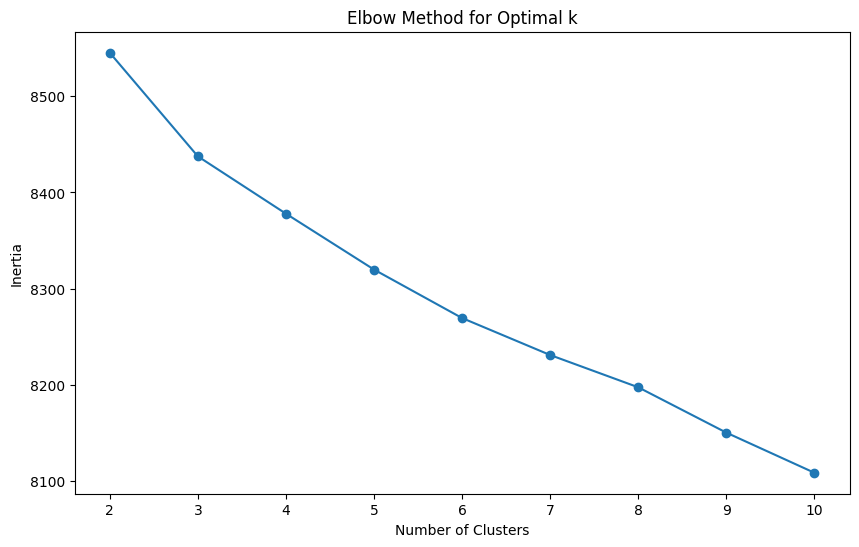

In [ ]:
# 1. Determining the optimal number of clusters (Elbow Method)
inertia = []
range_n_clusters = range(2, 11)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    kmeans.fit(X_vec)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

Optimal number of clusters based on silhouette score: 7


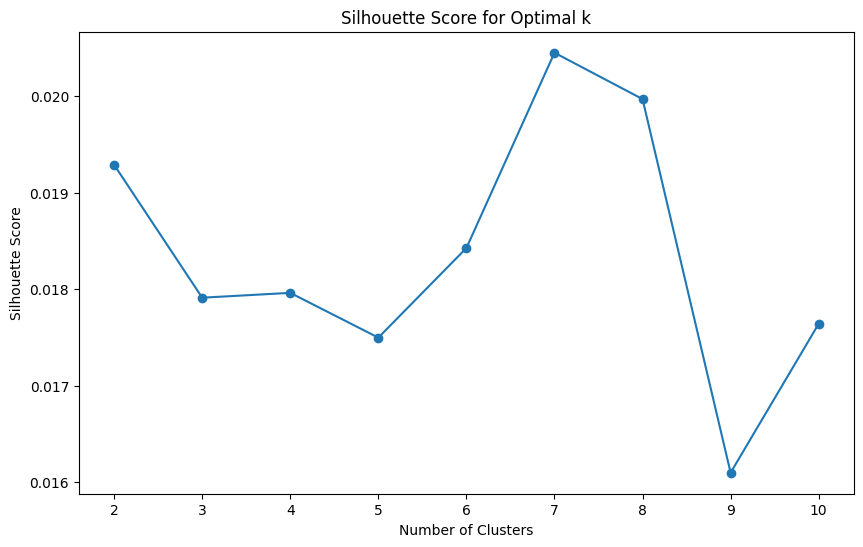

In [ ]:
silhouette_scores = []
range_n_clusters = range(2, 11)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(X_vec)
    silhouette_avg = silhouette_score(X_vec, cluster_labels)
    silhouette_scores.append(silhouette_avg)

best_k_silhouette = range_n_clusters[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on silhouette score: {best_k_silhouette}")

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [ ]:
n_clusters = 7 # from elbow

# 2. Applying the K-Means algorithm
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(X_vec)

In [ ]:
# 3. Investigating the clusters

print("Top terms per cluster:")
vocab = vectorizer.get_feature_names_out()

for i in range(kmeans.n_clusters):
    centroid = kmeans.cluster_centers_[i]
    sorted_terms = centroid.argsort()[::-1]
    print(f"Cluster {i}:\t{[vocab[j] for j in sorted_terms[:10]]}")

Top terms per cluster:
Cluster 0:	['number', '=', 'determine', 'n', 'integer', 'p', 'value', 'calculate', 'given', '-']
Cluster 1:	['\\in', 'x', '=', 'let', 'f', 'space', 'set', '\\mathbb{r}', 'function', 'determine']
Cluster 2:	['+', '=', '-', 'x^2', 'value', 'x', 'y^2', 'n', 'integer', 'given']
Cluster 3:	['=', 'equation', 'differential', 'solution', '+', 'initial', 'solve', '-', 'condition', 'given']
Cluster 4:	['integral', '\\,', 'evaluate', 'dx', 'dz', '=', 'contour', '+', 'circle', 'using']
Cluster 5:	['limit', 'evaluate', '\\to', '\\lim_{x', '\\infty}', '\\lim_{n', '\\lim_{x\\to', 'calculate', '-', '\\left(']
Cluster 6:	['random', 'x', 'y', '&', 'variables', '=', 'probability', 'independent', '<', '\\sim']


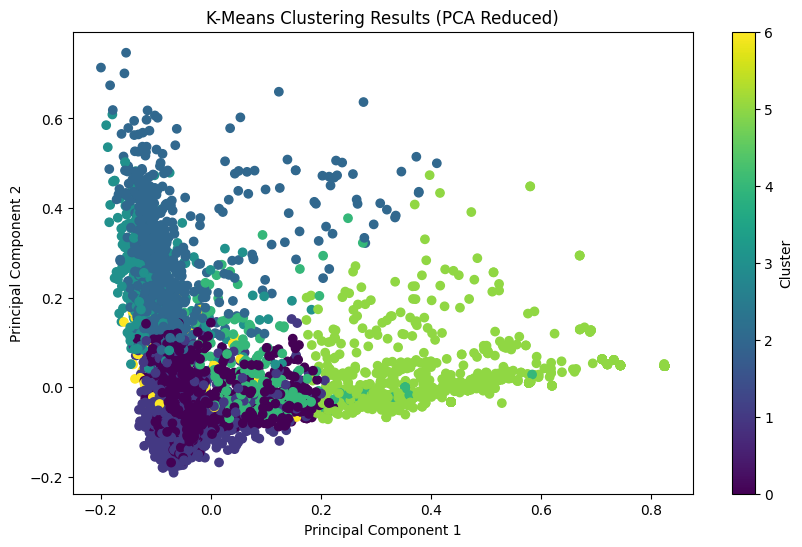

In [ ]:
# 4. Visualizing the clusters (using PCA for dimensionality reduction)
pca = PCA(n_components=2)
reduced_features2d = pca.fit_transform(X_vec.toarray())

plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_features2d[:, 0], reduced_features2d[:, 1], c=cluster_labels, cmap='viridis')
plt.title('K-Means Clustering Results (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

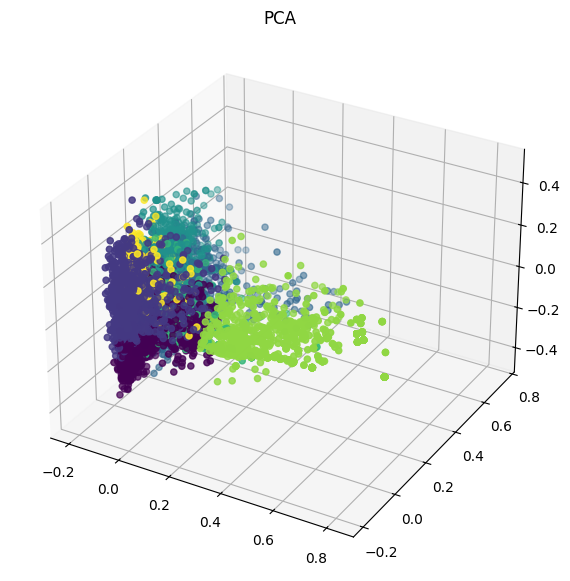

In [ ]:
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(X_vec.toarray())

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2], c=cluster_labels, cmap='viridis')
plt.title('PCA')
plt.show()

### DBScan

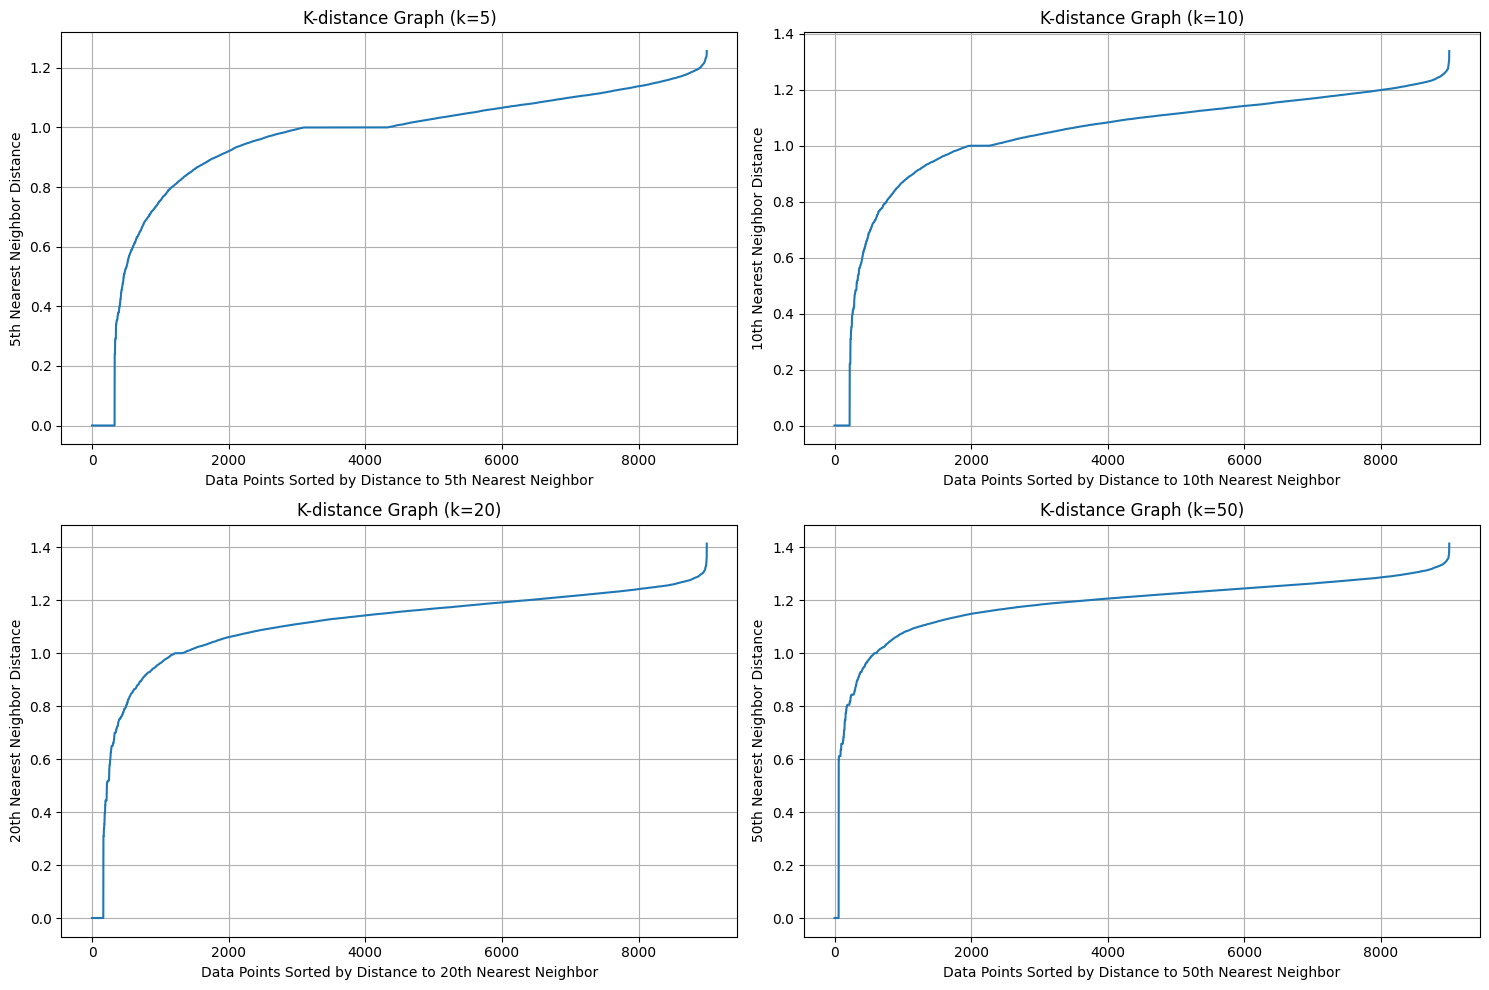

In [ ]:
# 1. Parameter Optimization for 'eps' using k-distance graphs for different 'k'
n_neighbors_values = [5, 10, 20, 50]
plt.figure(figsize=(15, 10))

for i, n_neighbors_value in enumerate(n_neighbors_values):
    neighbors = NearestNeighbors(n_neighbors=n_neighbors_value)
    neighbors_fit = neighbors.fit(X_vec)
    distances, indices = neighbors_fit.kneighbors(X_vec)
    distances = np.sort(distances, axis=0)
    distances = distances[:, n_neighbors_value - 1]
    plt.subplot(2, 2, i + 1)
    plt.plot(distances)
    plt.title(f'K-distance Graph (k={n_neighbors_value})')
    plt.xlabel('Data Points Sorted by Distance to {}th Nearest Neighbor'.format(n_neighbors_value))
    plt.ylabel(f'{n_neighbors_value}th Nearest Neighbor Distance')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Based on the k-distance graphs, choose a few potential 'eps' values to test
potential_eps_values = np.linspace(0.8, 1.1, 10)
min_samples_values = [5, 10, 15]
results = []

for eps in potential_eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(X_vec)
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        n_noise = list(cluster_labels).count(-1)

        silhouette_avg = -1
        if n_clusters > 1 and n_noise < len(cluster_labels)*0.8:
            silhouette_avg = silhouette_score(X_vec[cluster_labels != -1], cluster_labels[cluster_labels != -1])

        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette_score': silhouette_avg
        })

results_df = pd.DataFrame(results)
print("\nComparison of DBSCAN results for different parameters:")
print(results_df.sort_values(by='silhouette_score', ascending=False))


Comparison of DBSCAN results for different parameters:
         eps  min_samples  n_clusters  n_noise  silhouette_score
3   0.833333            5          62     7152          0.086544
14  0.933333           15          14     7114          0.042690
6   0.866667            5          53     6883          0.034388
17  0.966667           15          16     6637          0.030276
13  0.933333           10          26     6667          0.026601
10  0.900000           10          20     7105          0.020245
16  0.966667           10          22     6118          0.009620
9   0.900000            5          58     6444         -0.001592
12  0.933333            5          50     5972         -0.020042
15  0.966667            5          49     5329         -0.028753
5   0.833333           15          14     7883         -1.000000
4   0.833333           10          23     7609         -1.000000
2   0.800000           15          15     8045         -1.000000
1   0.800000           10         

In [ ]:
# Extract the parameters with the highest Silhouette Score
best_result = results_df.sort_values(by='silhouette_score', ascending=False).iloc[0]

best_eps = best_result['eps']
best_min_samples = int(best_result['min_samples'])
best_silhouette_score = best_result['silhouette_score']
best_n_clusters = best_result['n_clusters']
best_n_noise = best_result['n_noise']

print("\nBest DBSCAN parameters based on Silhouette Score:")
print(f"  eps: {best_eps}")
print(f"  min_samples: {best_min_samples}")
print(f"  Silhouette Score: {best_silhouette_score:.4f}")
print(f"  Number of Clusters: {best_n_clusters}")
print(f"  Number of Noise Points: {best_n_noise}")


Best DBSCAN parameters based on Silhouette Score:
  eps: 0.8333333333333334
  min_samples: 5
  Silhouette Score: 0.0865
  Number of Clusters: 62.0
  Number of Noise Points: 7152.0


In [ ]:
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
labels_dbscan = dbscan.fit_predict(X_vec)

In [ ]:
print("Top terms per DBSCAN cluster (excluding noise):")
#vocab = vectorizer.get_feature_names_out()

for label in range(max(labels_dbscan)+1):
    # Get indices of data points belonging to the current cluster
    cluster_indices = np.where(labels_dbscan == label)[0]
    cluster_samples = X_vec[cluster_indices]

    if cluster_samples.shape[0] > 0:
        # Calculate the mean TF-IDF vector for the cluster
        mean_tfidf = np.array(cluster_samples.mean(axis=0))[0]

        # Sort terms by their mean TF-IDF score in descending order
        sorted_indices = np.argsort(mean_tfidf)[::-1]
        top_terms = [vocab[i] for i in sorted_indices[:10]]
        print(f"Cluster {label}:\t{top_terms}")
    else:
        print(f"Cluster {label}:\t(empty)")

# Analyze noise points (label -1) if present
if -1 in labels_dbscan:
    noise_indices = np.where(labels_dbscan == -1)[0]
    print(f"\nNumber of noise points: {len(noise_indices)}")
    print("Example noise points:",)
    maxind = min(10,len(noise_indices))
    for idx in range(maxind):
        print(f"  {idx}: {train_clust[idx]}")

Top terms per DBSCAN cluster (excluding noise):
Cluster 0:	['limit', 'evaluate', '\\to', '+', '\\lim_{x', '\\infty}', '\\lim_{n', '-', '\\lim_{x\\to', 'calculate']
Cluster 1:	['\\lim_{t\\to', 'limit', 'evaluate', '\\sum_{n=0}^\\infty', 'exists', 'calculate', '+', 'determine', 'contains', 'containing']
Cluster 2:	['\\lim_{(x,y)\\to', 'limit', 'evaluate', 'exists', '(0,0)', '(0,0)}', 'xy', 'determine', 'considered', 'containing']
Cluster 3:	['\\lim_{x\\to0}', 'limit', 'evaluate', 'calculate', 'compute', 'context', 'contains', 'containing', 'contained', 'contain']
Cluster 4:	['\\lim_{z', '\\right', '(', 'limit', '\\left', 'evaluate', '\\to', ')', '\\infty}', '+']
Cluster 5:	['\\lim_{n\\rightarrow', 'limit', 'evaluate', '\\infty}', 'approximation', 'using', 's', '\\sum', '}', 'e']
Cluster 6:	['\\cos', '+', 'x', '\\sin', 'evaluate', '}', 'limit', 'triangle', 'f(x)', 'c']
Cluster 7:	['\\lim_{n\\rightarrow\\infty}', 'limit', 'evaluate', 'compute', 'calculate', 'context', 'contains', 'containi

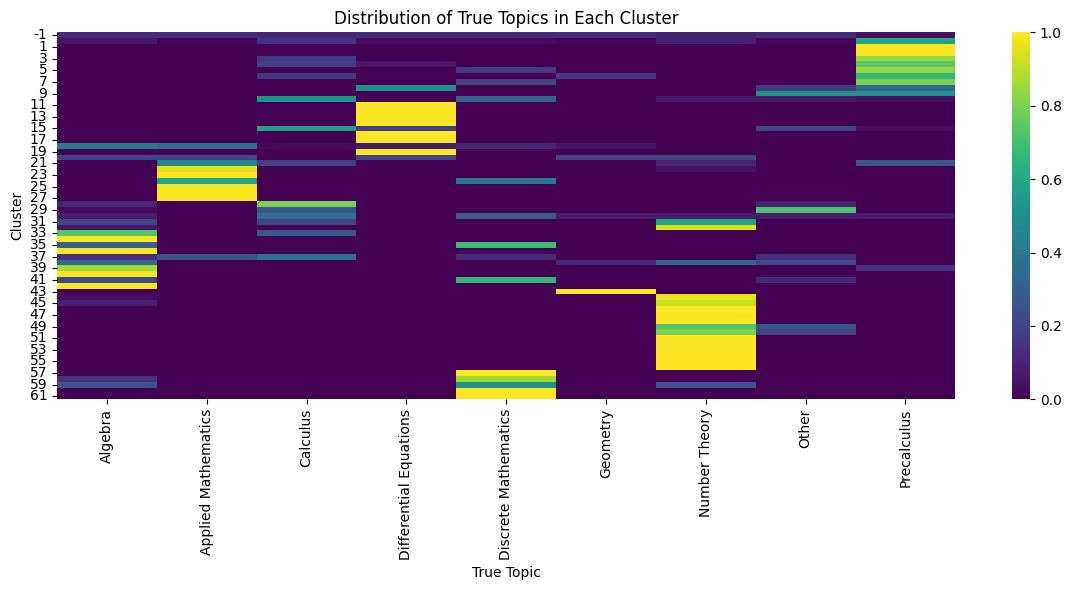

In [ ]:
import seaborn as sns

# Create a DataFrame to tabulate results
df_vis = pd.DataFrame({
    'Cluster': labels_dbscan,
    'Topic': labels_clust
})

# Filter out noise if using DBSCAN (-1 means noise)
#df_vis = df_vis[df_vis['Cluster'] != -1]

# Create a contingency table (Cluster x Topic)
cluster_topic_counts = pd.crosstab(df_vis['Cluster'], df_vis['Topic'])

# Normalize rows for proportion visualization
cluster_topic_props = cluster_topic_counts.div(cluster_topic_counts.sum(axis=1), axis=0)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_topic_props, annot=False, cmap="viridis", cbar=True)
plt.title("Distribution of True Topics in Each Cluster")
plt.xlabel("True Topic")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()


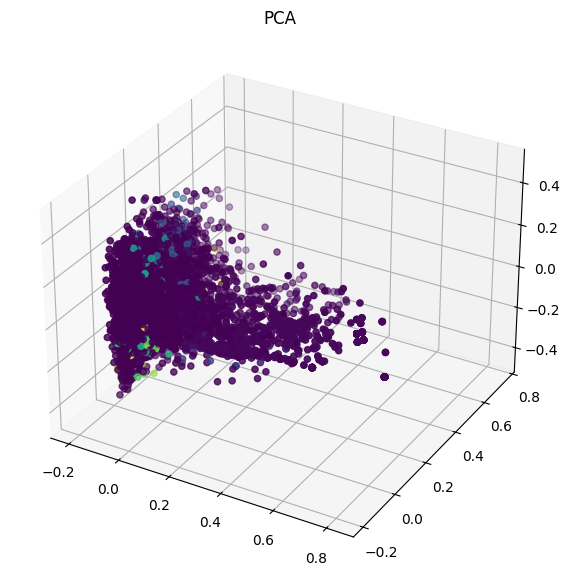

In [ ]:
#pca = PCA(n_components=3)
#reduced_features = pca.fit_transform(X_vec.toarray())

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2], c=labels_dbscan, cmap='viridis')
plt.title('PCA')
plt.show()

### Hierarchical clustering

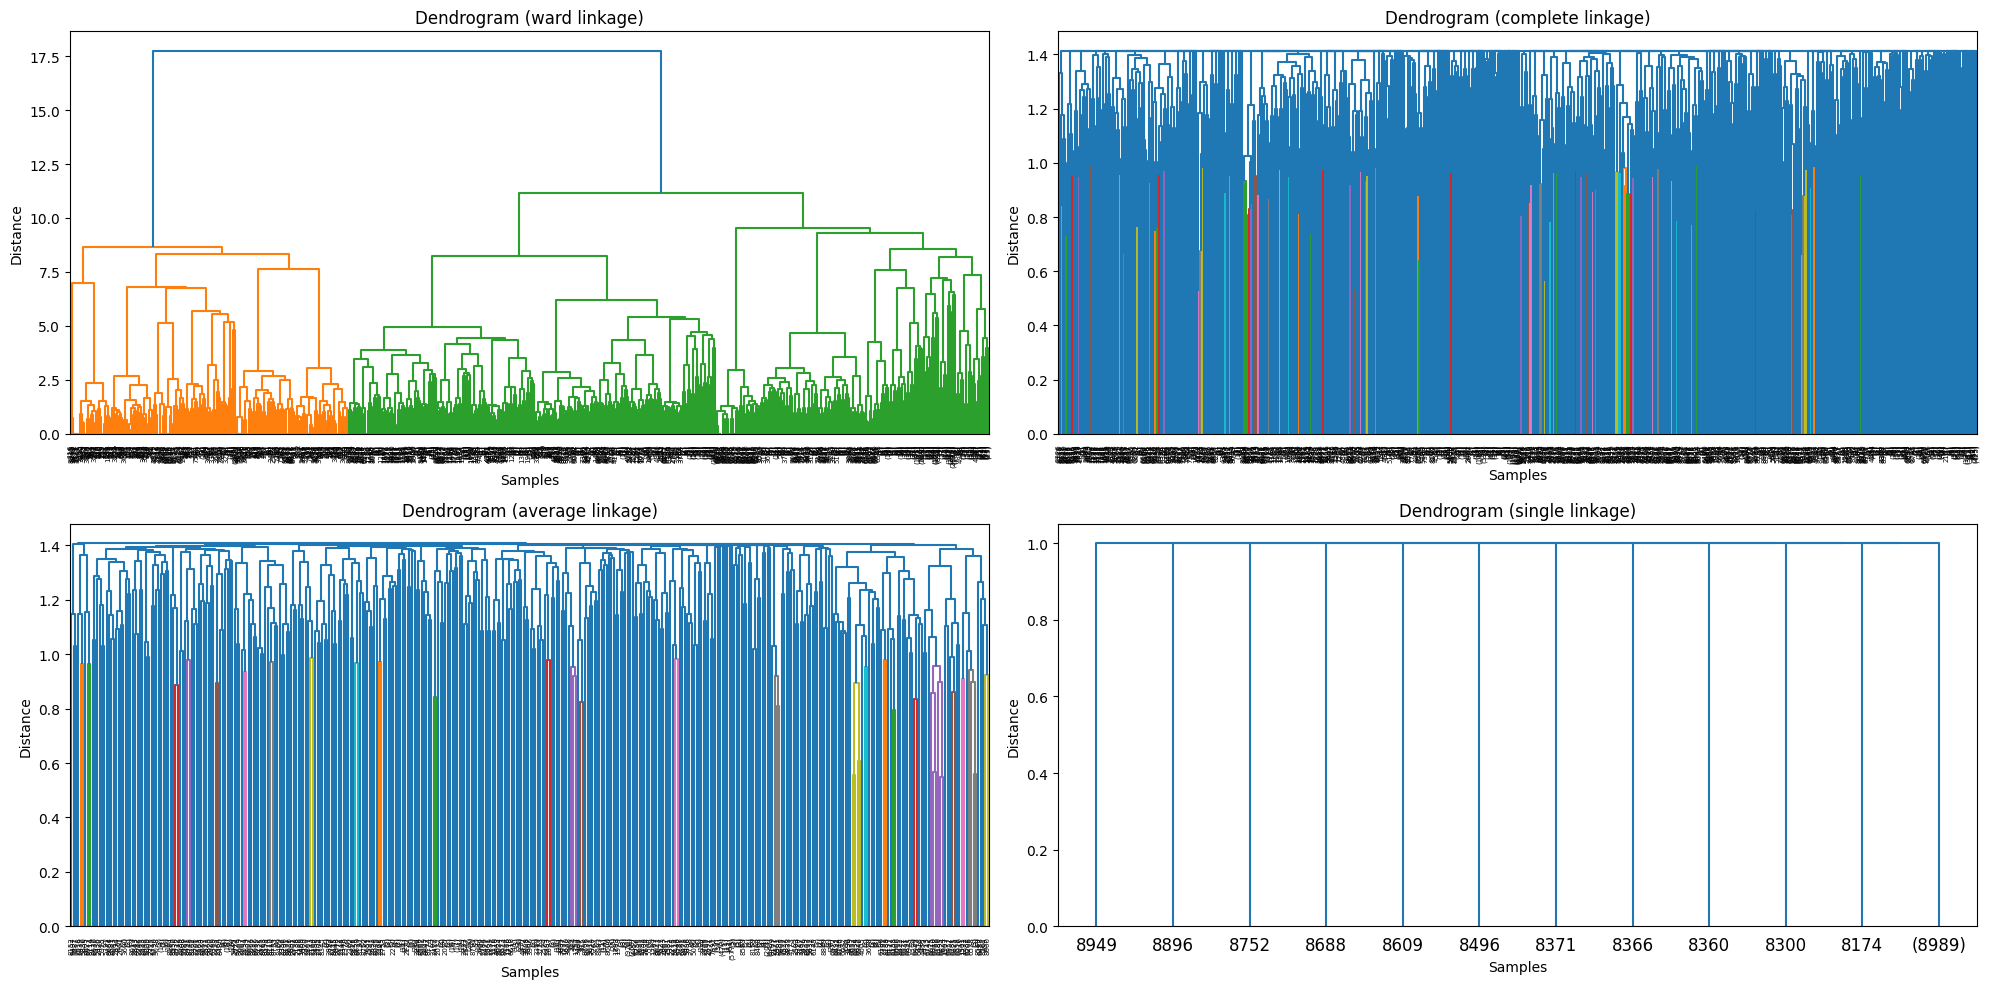

In [ ]:
# Linkage methods to compare
methods = ['ward', 'complete', 'average','single']

# Plot each dendrogram
plt.figure(figsize=(20, 10))

for i, method in enumerate(methods):
    plt.subplot(2, 2, i + 1)
    linked = linkage(X_vec.toarray(), method=method)
    dendrogram(linked, truncate_mode='level', p=10)
    plt.title(f'Dendrogram ({method} linkage)')
    plt.xlabel('Samples')
    plt.ylabel('Distance')

plt.tight_layout()
plt.show()


In [ ]:
# Fit Agglomerative Clustering with Ward linkage
n_clusters = 3
model_hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
labels_hierarchical = model_hierarchical.fit_predict(X_vec.toarray())

df = pd.DataFrame({
    'cluster': labels_hierarchical,  # Clustering results
    'topic': labels_clust            # Topic labels
})

# Create a pivot table to visualize the distribution of topics across clusters
topic_distribution = pd.crosstab(df['cluster'], df['topic'], rownames=['Cluster'], colnames=['Topic'])
print(topic_distribution)

Topic    Algebra  Applied Mathematics  Calculus  Differential Equations  \
Cluster                                                                   
0            801                  927       756                     408   
1             23                   18       103                       9   
2            176                   55       141                     583   

Topic    Discrete Mathematics  Geometry  Number Theory  Other  Precalculus  
Cluster                                                                     
0                         906       935            837    924          208  
1                          20         1             41     27          665  
2                          74        64            122     49          127  


In [ ]:
print("Top terms per hierarchical clusters:")
#vocab = vectorizer.get_feature_names_out()

for label in range(max(labels_hierarchical)+1):
    # Get indices of data points belonging to the current cluster
    cluster_indices = np.where(labels_hierarchical == label)[0]
    cluster_samples = X_vec[cluster_indices]

    if cluster_samples.shape[0] > 0:
        # Calculate the mean TF-IDF vector for the cluster
        mean_tfidf = np.array(cluster_samples.mean(axis=0))[0]

        # Sort terms by their mean TF-IDF score in descending order
        sorted_indices = np.argsort(mean_tfidf)[::-1]
        top_terms = [vocab[i] for i in sorted_indices[:10]]
        print(f"Cluster {label}:\t{top_terms}")
    else:
        print(f"Cluster {label}:\t(empty)")

Top terms per hierarchical clusters:
Cluster 0:	['=', 'x', 'determine', 'n', '+', 'number', '\\in', 'let', 'function', 'given']
Cluster 1:	['limit', 'evaluate', '\\to', '\\lim_{x', '\\infty}', '\\lim_{n', 'calculate', '\\lim_{x\\to', '-', '\\left(']
Cluster 2:	['+', '=', 'equation', 'differential', '-', 'solution', 'x', 'value', 'initial', 'solve']


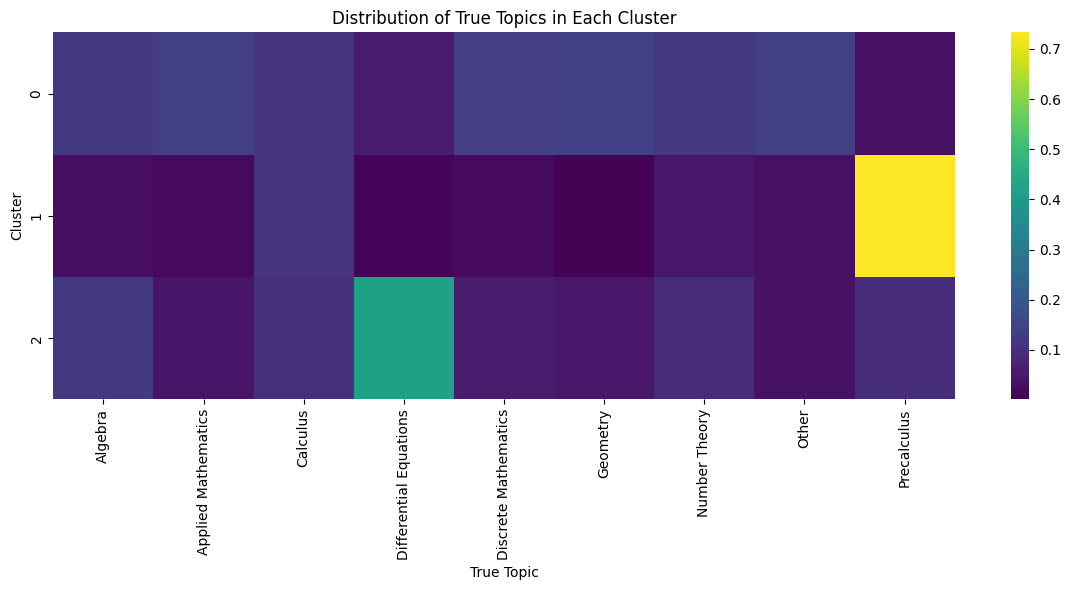

In [ ]:
#import seaborn as sns
df_vis = pd.DataFrame({
    'Cluster': labels_hierarchical,
    'Topic': labels_clust
})

# Create a contingency table (Cluster x Topic)
cluster_topic_counts = pd.crosstab(df_vis['Cluster'], df_vis['Topic'])

# Normalize rows for proportion visualization
cluster_topic_props = cluster_topic_counts.div(cluster_topic_counts.sum(axis=1), axis=0)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_topic_props, annot=False, cmap="viridis", cbar=True)
plt.title("Distribution of True Topics in Each Cluster")
plt.xlabel("True Topic")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()


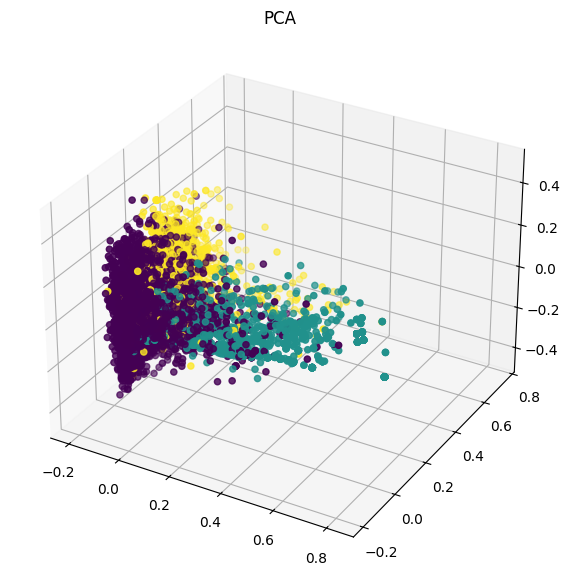

In [ ]:
#pca = PCA(n_components=3)
#reduced_features = pca.fit_transform(X_vec.toarray())

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2], c=labels_hierarchical, cmap='viridis')
plt.title('PCA')
plt.show()

### LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer #need this one for LDA

In [ ]:
tokenizer = Tokenizer('tree-walk', "allenai/longformer-base-4096", remove_numbers=True)
vectorizer_count = CountVectorizer(tokenizer=tokenizer.parse, lowercase=True, token_pattern=None, stop_words='english', min_df=5, max_df=.5)
vector_documents = vectorizer_count.fit_transform(train_clust)

vocab = vectorizer_count.get_feature_names_out()
print("Vocab length:", len(vocab))

Vocab length: 2540


In [ ]:
lda = LatentDirichletAllocation(n_components=5, verbose=1, learning_method='online', max_iter=30)
lda.fit(vector_documents)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30


LatentDirichletAllocation(learning_method='online', max_iter=30, n_components=5,
                          verbose=1)

In [ ]:
# Most important terms for each topic (n=3000)
for i in range(len(lda.components_)):
    sorted_terms = lda.components_[i].argsort()[::-1]
    concatenated_terms = '[' + ', '.join(vocab[i] for i in sorted_terms[:10]) + ']'
    print (f'Topic {i + 1}:\t', concatenated_terms)

Topic 1:	 [\in, let, x, =, set, m, f, space, k, determine]
Topic 2:	 [n, determine, number, &, p, integer, positive, \leq, integers, =]
Topic 3:	 [limit, evaluate, \to, number, \infty}, calculate, prime, n, l, -]
Topic 4:	 [=, +, x, -, y, function, equation, value, given, <]
Topic 5:	 [=, determine, point, given, solution, integral, c, b, points, triangle]


In [ ]:
# Most important terms for each topic (n=2000)
for i in range(len(lda.components_)):
    sorted_terms = lda.components_[i].argsort()[::-1]
    concatenated_terms = '[' + ', '.join(vocab[i] for i in sorted_terms[:10]) + ']'
    print (f'Topic {i + 1}:\t', concatenated_terms)

Topic 1:	 [\in, let, x, =, set, m, f, space, k, determine]
Topic 2:	 [n, determine, number, &, p, integer, positive, \leq, integers, =]
Topic 3:	 [limit, evaluate, \to, number, \infty}, calculate, prime, n, l, -]
Topic 4:	 [=, +, x, -, y, function, equation, value, given, <]
Topic 5:	 [=, determine, point, given, solution, integral, c, b, points, triangle]


In [ ]:
# Most important terms for each topic (n=1000)
for i in range(len(lda.components_)):
    sorted_terms = lda.components_[i].argsort()[::-1]
    concatenated_terms = '[' + ', '.join(vocab[i] for i in sorted_terms[:10]) + ']'
    print (f'Topic {i + 1}:\t', concatenated_terms)

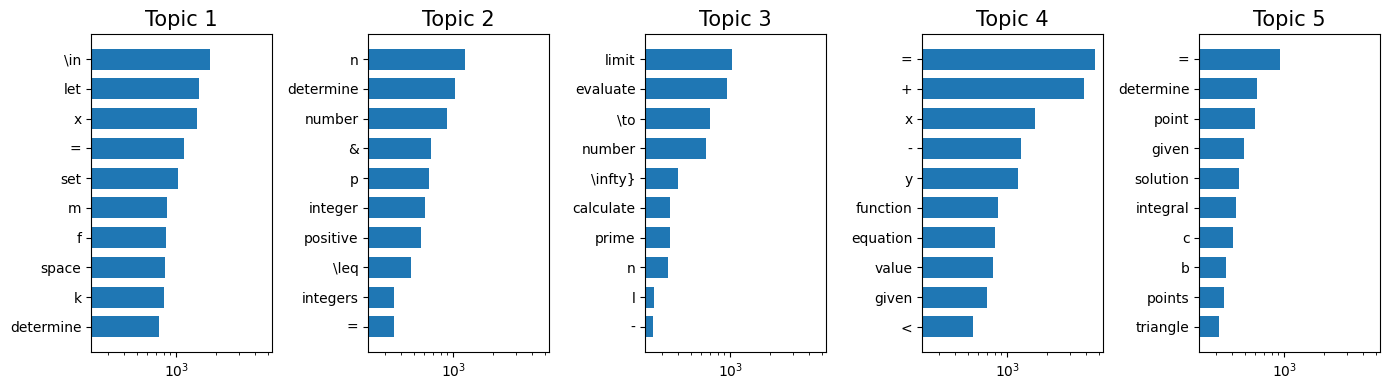

In [ ]:
num_words = 10
cols = 5
rows = int(len(lda.components_)/5)

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), sharex=True)
axes = axes.flatten()
for topic_idx, topic in enumerate(lda.components_):
    top_terms_index = topic.argsort()[:-num_words - 1:-1]
    top_terms = [vocab[i] for i in top_terms_index]
    weights = topic[top_terms_index]
    ax = axes[topic_idx]
    ax.barh(top_terms, weights, height=0.7)
    ax.set_title(f'Topic {topic_idx +1}',fontdict={'fontsize': 15})
    ax.invert_yaxis()
    ax.set_xscale('log')

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Analyse one document in particular
doc = train_clust[1160]
print(doc)

doc_vec = vectorizer.transform([doc])[0]
topic_vec = lda.transform(doc_vec)[0]
topic_vec

Solve the differential equation \(( D^4 + 6 D^3 + 9 D^2) y=0\), where \(D = \frac{d}{dx}\), with the initial conditions \(x=0,  y=0,  y'=0,  y''= 6\), and the asymptotic condition that as \(x\) tends to \(+\infty\), \(y'\) tends to \(1\). Find the value of \(y\) when \(x = 1\).


array([0.04079199, 0.04074967, 0.09023185, 0.60173386, 0.22649264])

In [ ]:
sorted_topics = topic_vec.argsort()[::-1]
sorted_prevalence = sorted(topic_vec)[::-1]

# Relevance and top terms for the question for each topic
for i in range(len(sorted_prevalence)):
    if sorted_prevalence[i] < .01: break
    topic = sorted_topics[i]
    sorted_terms = np.flip(lda.components_[topic].argsort())
    print (f'{100 * sorted_prevalence[i]:.1f}% Topic {topic}: {" ".join(vocab[i] for i in sorted_terms[:10])}')

60.2% Topic 3: = + x - y function equation value given <
22.6% Topic 4: = determine point given solution integral c b points triangle
9.0% Topic 2: limit evaluate \to number \infty} calculate prime n l -
4.1% Topic 0: \in let x = set m f space k determine
4.1% Topic 1: n determine number & p integer positive \leq integers =


### 30 components

In [ ]:
# Most important terms for each topic (for 30 components)
for i in range(len(lda.components_)):
    sorted_terms = lda.components_[i].argsort()[::-1]
    concatenated_terms = '[' + ', '.join(vocab[i] for i in sorted_terms[:10]) + ']'
    print (f'Topic {i + 1}:\t', concatenated_terms)

In [ ]:
num_words = 10
cols = 5
rows = int(len(lda.components_)/5)

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), sharex=True)
axes = axes.flatten()
for topic_idx, topic in enumerate(lda.components_):
    top_terms_index = topic.argsort()[:-num_words - 1:-1]
    top_terms = [vocab[i] for i in top_terms_index]
    weights = topic[top_terms_index]
    ax = axes[topic_idx]
    ax.barh(top_terms, weights, height=0.7)
    ax.set_title(f'Topic {topic_idx +1}',fontdict={'fontsize': 15})
    ax.invert_yaxis()
    ax.set_xscale('log')

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Analyse one document in particular

doc = train_clust[6033]
print(doc)

In [ ]:
doc_vec = vectorizer.transform([doc])[0]
topic_vec = lda.transform(doc_vec)[0]
topic_vec

In [ ]:
sorted_topics = topic_vec.argsort()[::-1]
sorted_prevalence = sorted(topic_vec)[::-1]

In [ ]:
# Relevance and top terms for the question for each topic
for i in range(10):
    if sorted_prevalence[i] < .01: break
    topic = sorted_topics[i]
    sorted_terms = np.flip(lda.components_[topic].argsort())
    print (f'{100 * sorted_prevalence[i]:.1f}% Topic {topic}: {" ".join(vocab[i] for i in sorted_terms[:10])}')

### Optimization

In [ ]:
from sklearn.model_selection import train_test_split

documents_train, documents_test= train_test_split(train_clust, test_size=0.2, random_state=11)
print('No. training docs:', len(documents_train))
print('No. testing docs:', len(documents_test))

tokenizer = Tokenizer('tree-walk', "allenai/longformer-base-4096", remove_numbers=True)
vectorizer_count = CountVectorizer(tokenizer=tokenizer.parse, lowercase=True,token_pattern=None, stop_words='english', min_df=5, max_df=.5)
vector_documents_train = vectorizer_count.fit_transform(documents_train)
vector_documents_test = vectorizer_count.fit_transform(documents_test)

vocab = vectorizer_count.get_feature_names_out()
print("Vocab length:", len(vocab))

No. training docs: 7200
No. testing docs: 1800
Vocab length: 805


Number of Topics: 5, Perplexity: 14771.9324
Number of Topics: 7, Perplexity: 16621.5897
Number of Topics: 10, Perplexity: 19754.3915
Number of Topics: 12, Perplexity: 19298.6143
Number of Topics: 15, Perplexity: 21309.2955


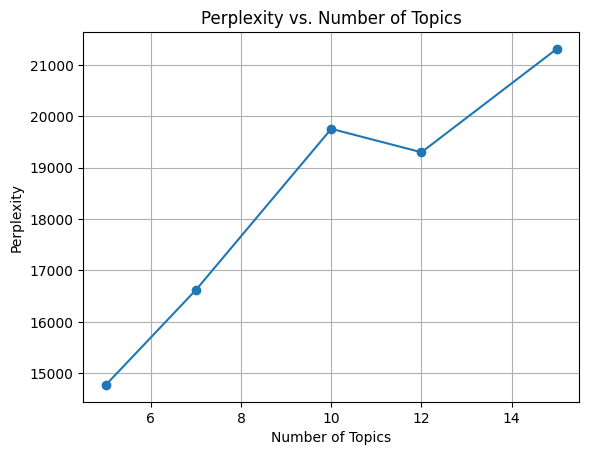

In [ ]:
perplexity_values = {}
topic_range = [5, 7, 10, 12, 15]

for n_topics in topic_range:
    lda = LatentDirichletAllocation(n_components=n_topics, verbose=0,
                                    learning_method='online', max_iter=30,
                                    random_state=42)
    lda.fit(vector_documents_train)
    perplexity = lda.perplexity(vector_documents_test)
    perplexity_values[n_topics] = perplexity
    print(f"Number of Topics: {n_topics}, Perplexity: {perplexity:.4f}")

plt.plot(list(perplexity_values.keys()), list(perplexity_values.values()), marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")
plt.title("Perplexity vs. Number of Topics")
plt.grid(True)
plt.show()

## Perform document index on different fields

In [ ]:
!pip install -q python-terrier==0.11.0 #now there is another version but we don't use it

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.5/119.5 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.0/859.0 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.0/288.0 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.0/135.0 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.9 MB/s eta 0:00:00


In [ ]:
import os
os.environ["JAVA_HOME"] = "/opt/homebrew/Cellar/openjdk@11/11.0.21/libexec/openjdk.jdk/Contents/Home"
os.environ["JVM_PATH"] = "/opt/homebrew/Cellar/openjdk@11/11.0.26/libexec/openjdk.jdk/Contents/Home/lib/server/libjvm.dylib"

In [ ]:
# 2. Initialize PyTerrier (only once)
import pyterrier as pt

# google colab
if not pt.started():
  pt.init()

# vs code in mac
'''
if not pt.java.started():
    pt.init()
'''

<ipython-input-72-f8018f4f8077>:5: DeprecationWarning: Call to deprecated function (or staticmethod) started. (use pt.java.started() instead) -- Deprecated since version 0.11.0.
  if not pt.started():


terrier-assemblies 5.11 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...
Done


Java started and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]
<ipython-input-72-f8018f4f8077>:6: DeprecationWarning: Call to deprecated method pt.init(). Deprecated since version 0.11.0.
java is now started automatically with default settings. To force initialisation early, run:
pt.java.init() # optional, forces java initialisation
  pt.init()


'\nif not pt.java.started():\n    pt.init()\n'

### Finding "quadratic form" in 'question'

In [ ]:
# 3. Build a corpus iterator over the 'question' field
def get_question_corpus(ds):
    for i, example in ds.iterrows():
        yield {
            'docno': str(i),                          # unique document ID
            'question': example['question']           # only the question text
        }

# 4. Index into a new folder, specifying that we only want the 'question' field
pt_index_path = './terrier_deepmath_questions'
indexer = pt.index.IterDictIndexer(pt_index_path, overwrite=True, meta_reverse=[])
index_ref = indexer.index(
    get_question_corpus(train_ds),
    fields=('question',),
    meta=('docno', 'question')  # store docno + question in the metadata
)

# 5. Load the index and run a TF-IDF retrieval over the 'question' field
index = pt.IndexFactory.of(index_ref)
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")
results = tfidf.search("quadratic form")
print(results.head(6))

<ipython-input-74-642ea571bc22>:20: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")


  qid  docid  docno  rank     score           query
0   1  29503  29503     0  9.515057  quadratic form
1   1  95512  95512     1  9.180091  quadratic form
2   1  96657  96657     2  9.049501  quadratic form
3   1  97982  97982     3  9.049501  quadratic form
4   1  10764  10764     4  8.987363  quadratic form
5   1   7207   7207     5  8.977920  quadratic form


### Perform a 'question' search in only documents with x difficulty

In [ ]:
# Impose difficulty = 0.0
filtered_ds = train_ds[train_ds['difficulty'] == 0.0]

# Build a corpus iterator over the 'question' field
def get_question_corpus(ds):
    for i, example in ds.iterrows():
        yield {
            'docno': str(i),                          # unique document ID
            'question': example['question']           # only the question text
        }

# Index into a new folder, specifying that we only want the 'question' field
pt_index_path = './terrier_deepmath_questions'
indexer = pt.index.IterDictIndexer(pt_index_path, overwrite=True, meta_reverse=[])
index_ref = indexer.index(
    get_question_corpus(filtered_ds),
    fields=('question',),
    meta=('docno', 'question')
)

# Load the index and run a TF-IDF retrieval over the 'question' field
index = pt.IndexFactory.of(index_ref)
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")
query = "quadratic form"
query1 = "quadratic form optimization minimize" #puoi mettere piu parole e funziona
results = tfidf.search(query)
print(results.head(6))

<ipython-input-77-a27ebebe6dcd>:23: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")


  qid  docid  docno  rank     score           query
0   1  29503  29503     0  9.515057  quadratic form
1   1  95512  95512     1  9.180091  quadratic form
2   1  96657  96657     2  9.049501  quadratic form
3   1  97982  97982     3  9.049501  quadratic form
4   1  10764  10764     4  8.987363  quadratic form
5   1   7207   7207     5  8.977920  quadratic form


### Finding 'quadratic form' in more fields (NON RIUSCITO)

## Generate embeddings and analyze them

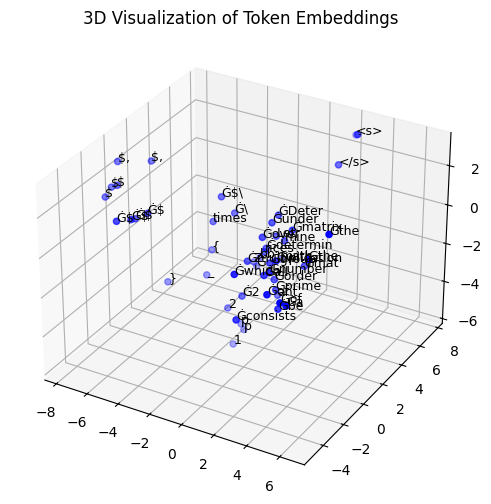

In [ ]:
# TODO: fix! clusterize whole sentences

# Example token IDs (replace with your token IDs)
token_id = token_ids[45]

model = AutoModel.from_pretrained(model_name)

# Convert token IDs to embeddings
input_ids = torch.tensor([token_id])  # Add batch dimension
with torch.no_grad():
    outputs = model(input_ids)
    embeddings = outputs.last_hidden_state.squeeze(0)  # Shape: (seq_len, hidden_dim)

# Reduce dimensions to 3D using PCA
pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(embeddings)

# Visualize in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c='blue', marker='o')

# Annotate tokens
tokens = tokenizer.convert_ids_to_tokens(token_id)
for i, token in enumerate(tokens):
    ax.text(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], token, fontsize=9)

ax.set_title("3D Visualization of Token Embeddings")
plt.show()

# Training

## M1C: Base model (topic classification)

initial investigation on which classification method works better for this dataset

In [ ]:
# TODO: investigate different tokenizers and fitting performance (curretnly using hybrid-math)
# TODO: research if max iter matters (from litterature)

In [12]:
PARSER = 'hybrid-math'

In [16]:
print('Working on', train_ds_qs.shape, 'samples')

Working on (103110,) samples


config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

fitted: LinearSVC(max_iter=10000)
fitted: SGDClassifier(class_weight='balanced', max_iter=10000)
fitted: SGDClassifier(class_weight='balanced', loss='log_loss', max_iter=10000)
fitted: LogisticRegression(max_iter=1000, n_jobs=-1)
fitted: MultinomialNB()


,model,accuracy,macro_f1
0,LinearSVC,0.636020,0.437565
1,SGD-hinge,0.514063,0.354600
3,LogisticRegression,0.617932,0.353479
2,SGD-log,0.492096,0.346199
4,MultinomialNB,0.435021,0.130187


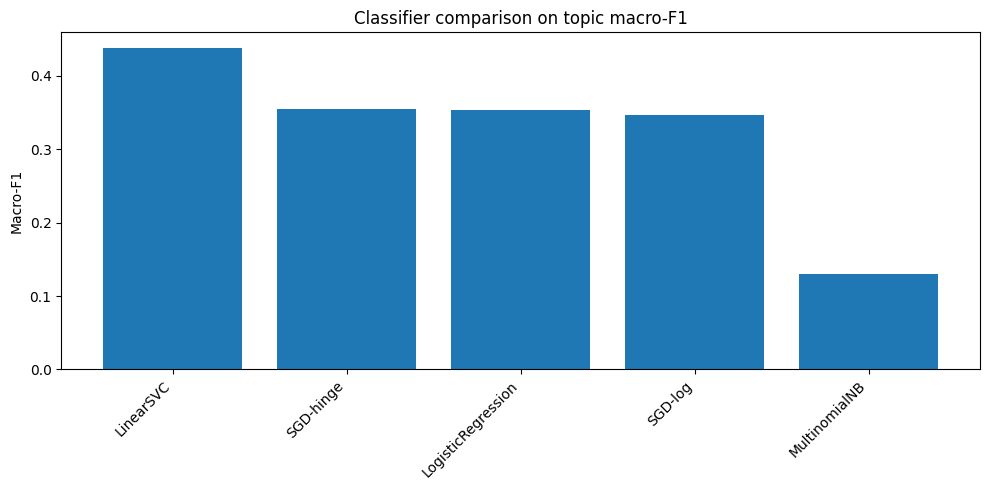

Best model: LinearSVC
Accuracy: 0.6360197846959558
Macro-F1: 0.4375652616210552
Best model class: <class 'sklearn.svm._classes.LinearSVC'>


In [16]:
X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    train_ds_qs, train_ds_tp,
    test_size=0.2, random_state=seed,
    stratify=train_ds_tp
)

# 2. Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test  = le.transform(y_test_raw)

counts = Counter(y_train)
total = len(y_train)

# Inverse‐frequency weights
weights = {cls: total/(len(counts)*cnt) for cls, cnt in counts.items()}

# 3. Select tokenizer
tokenizer = Tokenizer(PARSER, "allenai/longformer-base-4096", remove_numbers=True)

# 4. Define a suite of classifiers to compare
classifiers = {
    "LinearSVC":             LinearSVC(max_iter=10000),
    "SGD-hinge":             SGDClassifier(loss="hinge", class_weight="balanced", max_iter=10000),
    "SGD-log":               SGDClassifier(loss="log_loss",  class_weight="balanced", max_iter=10000),
    "LogisticRegression":    LogisticRegression(max_iter=1000, n_jobs=-1),
    "MultinomialNB":         MultinomialNB(),
}

classifiers_classes = {
    "LinearSVC":             LinearSVC,
    "SGD-hinge":             SGDClassifier,
    "SGD-log":               SGDClassifier,
    "LogisticRegression":    LogisticRegression,
    "MultinomialNB":         MultinomialNB,
}

vectorizer =  TfidfVectorizer(
    tokenizer=tokenizer.parse,
    lowercase=True,
    token_pattern=None
)
X_train_vectorized =  vectorizer.fit_transform(X_train)
X_test_vectorized =  vectorizer.transform(X_test)

# 5. Train, predict, record metrics
results = []
for name, clf in classifiers.items():
    clf.fit(X_train_vectorized, y_train)
    print("fitted:",clf)
    yp = clf.predict(X_test_vectorized)
    results.append({
        "model":    name,
        "accuracy": accuracy_score(y_test, yp),
        "macro_f1": f1_score(y_test, yp, average="macro")
    })

df = pd.DataFrame(results).sort_values("macro_f1", ascending=False)
display(df)

# 6. Plot macro-F1 for easy comparison
plt.figure(figsize=(10,5))
plt.bar(df["model"], df["macro_f1"])
plt.ylabel("Macro-F1")
plt.xticks(rotation=45, ha="right")
plt.title("Classifier comparison on topic macro-F1")
plt.tight_layout()
plt.show()

# Find the best model based on macro_f1
best_result = max(results, key=lambda x: x["macro_f1"])
best_model_name = best_result["model"]

print(f"Best model: {best_model_name}")
print(f"Accuracy: {best_result['accuracy']}")
print(f"Macro-F1: {best_result['macro_f1']}")

# Retrieve the corresponding classifier from the classifiers dictionary
best_model_class = classifiers_classes[best_model_name]
print(f"Best model class: {best_model_class}")



Tune the best model with optuna

NB: 50k iters does not reach convergence atm (with tree-walk parser), try with more iters.
NB: 10k iters does not reach convergence atm (with hybrid-math parser), try with more iters.

In [20]:
X       = train_ds_qs
y_raw   = train_ds_tp
le      = LabelEncoder()
y       = le.fit_transform(y_raw)

N_TRIALS = 2

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

from collections import Counter
counts = Counter(y_train)
total  = len(y_train)
n_cls  = len(counts)
weights = {
    cls : total/(n_cls * count)
    for cls, count in counts.items()
}

def objective(trial):
    # TF–IDF params
    ngram_min    = trial.suggest_int("ngram_min", 1, 2)
    ngram_max    = trial.suggest_int("ngram_max", ngram_min, 3)
    max_df       = trial.suggest_float("max_df", 0.5, 1.0)
    min_df       = trial.suggest_int("min_df", 1, 5)
    #max_features = int(trial.suggest_int("max_features", 10_000, 50_000, step=5_000))

    max_iter = 10000
    if best_model_name == "LinearSVC":
        C            = trial.suggest_float("C", 1e-4, 1e2, log=True)
        weight_choice = trial.suggest_categorical("weight_choice", ["none", "custom"])
        # penalty = trial.suggest_categorical("penalty", ["l1","l2"])
        # dual    = False    # l1 only works with dual=False
        if weight_choice == "none":
            class_weight = None
        else:
            class_weight = weights
        loss         = trial.suggest_categorical("loss", ["hinge", "squared_hinge"])
        dual         = True if loss == "hinge" else False
        model = best_model_class(
            C=C,
            class_weight=class_weight,
            loss=loss,
            dual=dual,
            max_iter=max_iter,
            random_state=seed
        )
    elif best_model_name in ["SGD-hinge", "SGD-log"]:
        loss         = trial.suggest_categorical("loss", ["hinge", "squared_hinge"])
        weight_choice = trial.suggest_categorical("weight_choice", ["none", "custom"])
        if weight_choice == "none":
            class_weight = None
        else:
            class_weight = weights
        model = best_model_class(
            class_weight=class_weight,
            loss=loss,
            max_iter=max_iter,
            random_state=seed
        )
    elif best_model_name == "LogisticRegression":
        model = best_model_class(
            max_iter=max_iter,
            n_jobs = 1
        )
    elif best_model_name == "MultinomialNB":
        model = best_model_class(
        )
    else:
        raise RuntimeError('not impl')


    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(
             tokenizer=tokenizer.parse,
             lowercase=True,
             token_pattern=None,
             ngram_range=(ngram_min, ngram_max),
             max_df=max_df,
             min_df=min_df,
             #max_features=max_features,
        )),
        ("clf", model)
    ])


    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    scorer = make_scorer(f1_score, average="macro")

    scores = cross_val_score(
        pipeline, X_train, y_train,
        cv=cv, scoring=scorer, n_jobs=1
    )
    return scores.mean()

study = optuna.create_study(direction="maximize", study_name=f"{best_model_name}_tuning")
study.optimize(objective, n_trials=N_TRIALS, timeout=3600)

best_macro_f1 = study.best_value
best_params = study.best_params

print("Best macro-F1:", study.best_value)
print("Best hyperparameters:", study.best_params)

[W 2025-05-14 21:38:50,222] Trial 0 failed with parameters: {'ngram_min': 2, 'ngram_max': 2, 'max_df': 0.6407121436499137, 'min_df': 3, 'C': 2.490426479080093, 'weight_choice': 'custom', 'loss': 'squared_hinge'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_35/117954419.py", line 94, in objective
    scores = cross_val_score(
             ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 515, in cross_val_score
    cv_results = cross_validate(
                 ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 266, in cross_validate
    results = parallel(
              ^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/util

KeyboardInterrupt: 

Best macro-F1: 0.22819337166898143
Best hyperparameters: {'ngram_min': 1, 'ngram_max': 2, 'max_df': 0.7832138168654517, 'min_df': 1, 'C': 44.281459120039905, 'weight_choice': 'none', 'loss': 'hinge'}

L'ets fit the model with the new params



In [8]:
X = train_ds_qs
y_raw = train_ds_tp
# 3. Select tokenizer
PARSER="hybrid-math"
tokenizer = Tokenizer(PARSER, "allenai/longformer-base-4096", remove_numbers=True)


X_train, X_test, y_train, y_test = train_test_split(
    X, y_raw, test_size=0.2, random_state=42,
	  stratify=y_raw
)
best_params={'ngram_min': 1, 'ngram_max': 2, 'max_df': 0.7832138168654517, 'min_df': 1, 'C': 4.28145912,'weight_choice':'none', 'loss': 'hinge'}

le = LabelEncoder()
y = le.fit_transform(y_raw)

def build_model(model_name):
    max_iter = 10000
    if model_name == "LinearSVC":
        model = LinearSVC(
            C=best_params['C'],
            class_weight=None,
            loss=best_params['loss'],
            max_iter=max_iter,
            random_state=seed
        )
    elif model_name in ["SGD-hinge", "SGD-log"]:
        model = best_model_class(
            class_weight=None,
            loss=best_params['loss'],
            max_iter=max_iter,
            random_state=seed
        )
    elif model_name == "LogisticRegression":
        model = best_model_class(
            max_iter=max_iter,
            n_jobs = 1
        )
    elif model_name == "MultinomialNB":
        model = best_model_class(
        )
    else:
        raise RuntimeError('not impl')
    return model
best_model_name="LinearSVC"
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        tokenizer=tokenizer.parse,
        lowercase=True,
        token_pattern=None, ngram_range=(best_params['ngram_min'], best_params['ngram_max']), max_df=best_params['max_df'], min_df=best_params['min_df']
    )),
    ("clf", build_model(best_model_name))
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.6337406653088934

Classification report:



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                                                                     precision    recall  f1-score   support

                                      Mathematics -> Algebra -> Abstract Algebra -> Category Theory       0.40      0.40      0.40         5
                                         Mathematics -> Algebra -> Abstract Algebra -> Field Theory       0.71      0.65      0.68       555
                                         Mathematics -> Algebra -> Abstract Algebra -> Group Theory       0.86      0.88      0.87       774
                                         Mathematics -> Algebra -> Abstract Algebra -> Lie Algebras       0.88      0.88      0.88         8
                                                Mathematics -> Algebra -> Abstract Algebra -> Other       0.48      0.45      0.46       303
                                          Mathematics -> Algebra -> Abstract Algebra -> Ring Theory       0.88      0.85      0.87       384
            

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Try sub topics

In [30]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"]      = "1"
os.environ["MKL_NUM_THREADS"]      = "1"

import joblib
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score


X_all = train_ds_qs.tolist()
topics_all = train_ds_tp.tolist()

PARSER="hybrid-math"
tokenizer = Tokenizer(PARSER, "allenai/longformer-base-4096", remove_numbers=True)

# Extract "branch" (top-level topic)
branches = []
for t in topics_all:
    parts = t.split(" -> ")
    branches.append(parts[1] if len(parts) > 1 else parts[0])

le_branch = LabelEncoder()
y_branch  = le_branch.fit_transform(branches)

X_train, X_test, y_branch_train, y_branch_test, idx_train, idx_test = train_test_split(
    X_all, y_branch, range(len(X_all)),
    test_size=0.2, random_state=42, stratify=y_branch
)

# Compute class weights
counts = Counter(y_branch_train)
total = len(y_branch_train)
n_cls = len(counts)
weights = {cls: total / (n_cls * count) for cls, count in counts.items()}

# Top-level classifier
pipe_stage1 = Pipeline([
    ("tfidf", TfidfVectorizer(
        tokenizer=tokenizer.parse, lowercase=True, token_pattern=None,
        ngram_range=(1, 2), max_df=0.652179599157025, min_df=1
    )),
    ("clf", LinearSVC(max_iter=10000, C=1.679602370511424, class_weight=None, loss='hinge'))
])
pipe_stage1.fit(X_train, y_branch_train)

# Subtopic classifiers
branch_pipelines = {}
branch_default = {}
le_topic_per_branch = {}

for branch_idx in sorted(set(y_branch_train)):
    inds = [i for i, b in enumerate(y_branch_train) if b == branch_idx]
    Xb = [X_train[i] for i in inds]
    Tb = [topics_all[idx_train[i]] for i in inds]

    uniq = sorted(set(Tb))
    if len(uniq) < 2:
        branch_default[branch_idx] = uniq[0]
        continue

    le_topic = LabelEncoder().fit(Tb)
    yb = le_topic.transform(Tb)
    le_topic_per_branch[branch_idx] = le_topic

    pipe_sub = Pipeline([
        ("tfidf", TfidfVectorizer(
            tokenizer=tokenizer.parse, lowercase=True, token_pattern=None,
            ngram_range=(1, 2), max_df=0.652179599157025, min_df=1
        )),
        ("clf", LinearSVC(max_iter=10000, C=1.679602370511424, class_weight=None, loss='hinge'))
    ])
    pipe_sub.fit(Xb, yb)
    branch_pipelines[branch_idx] = pipe_sub

# Evaluate branch classifier
y_pred_branch = pipe_stage1.predict(X_test)
print("=== Branch‐level ===")
print(classification_report(
    y_branch_test, y_pred_branch, target_names=le_branch.classes_
))

# Full-topic predictions
y_true_topic = [topics_all[i] for i in idx_test]
y_pred_topic = []
for q, b_pred in zip(X_test, y_pred_branch):
    if b_pred in branch_pipelines:
        sub_i = branch_pipelines[b_pred].predict([q])[0]
        sub_label = le_topic_per_branch[b_pred].inverse_transform([sub_i])[0]
    else:
        sub_label = branch_default[b_pred]
    y_pred_topic.append(sub_label)

print("\n=== Full‐topic Accuracy ===")
print("Accuracy:", accuracy_score(y_true_topic, y_pred_topic))
print(classification_report(y_true_topic, y_pred_topic))

# Per-branch subtopic evaluation
for branch_idx in sorted(set(y_branch_test)):
    branch_name = le_branch.inverse_transform([branch_idx])[0]
    print(f"\n--- Subtopic report for branch: {branch_name} ---")

    test_pairs = [
        (X_test[i], topics_all[idx_test[i]])
        for i, b in enumerate(y_branch_test)
        if b == branch_idx
    ]

    if branch_idx not in branch_pipelines:
        only_leaf = branch_default[branch_idx]
        print(f"Only one topic in this branch: {only_leaf}")
        continue

    pipe_sub = branch_pipelines[branch_idx]
    le_sub = le_topic_per_branch[branch_idx]

    Xb_test = [q for q, _ in test_pairs]
    yb_true = [t for _, t in test_pairs]

    yb_pred = [
        le_sub.inverse_transform(pipe_sub.predict([q]))[0]
        for q in Xb_test
    ]

    print(classification_report(yb_true, yb_pred))


config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Liblinear failed to converge, increase the number of iterations.


=== Branch‐level ===
                        precision    recall  f1-score   support

               Algebra       0.83      0.87      0.85      6550
   Applied Mathematics       0.88      0.87      0.87      1569
              Calculus       0.85      0.84      0.85      5656
Differential Equations       0.88      0.77      0.82       315
  Discrete Mathematics       0.76      0.68      0.72      1163
              Geometry       0.82      0.86      0.84      1681
         Number Theory       0.78      0.80      0.79      1169
                 Other       0.48      0.31      0.37       696
           Precalculus       0.74      0.81      0.78      1806

              accuracy                           0.82     20605
             macro avg       0.78      0.76      0.77     20605
          weighted avg       0.82      0.82      0.82     20605


=== Full‐topic Accuracy ===
Accuracy: 0.6400873574375152


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


                                                                                                     precision    recall  f1-score   support

                                      Mathematics -> Algebra -> Abstract Algebra -> Category Theory       0.00      0.00      0.00         6
                                         Mathematics -> Algebra -> Abstract Algebra -> Field Theory       0.70      0.67      0.69       547
                                         Mathematics -> Algebra -> Abstract Algebra -> Group Theory       0.84      0.89      0.86       741
                                         Mathematics -> Algebra -> Abstract Algebra -> Lie Algebras       0.50      0.60      0.55         5
                                                Mathematics -> Algebra -> Abstract Algebra -> Other       0.51      0.58      0.54       306
                                          Mathematics -> Algebra -> Abstract Algebra -> Ring Theory       0.90      0.85      0.87       365
            

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


                                                                         precision    recall  f1-score   support

          Mathematics -> Algebra -> Abstract Algebra -> Category Theory       0.00      0.00      0.00         6
             Mathematics -> Algebra -> Abstract Algebra -> Field Theory       0.76      0.73      0.74       547
             Mathematics -> Algebra -> Abstract Algebra -> Group Theory       0.90      0.91      0.90       741
             Mathematics -> Algebra -> Abstract Algebra -> Lie Algebras       0.50      0.60      0.55         5
                    Mathematics -> Algebra -> Abstract Algebra -> Other       0.62      0.70      0.66       306
              Mathematics -> Algebra -> Abstract Algebra -> Ring Theory       0.91      0.87      0.89       365
             Mathematics -> Algebra -> Algebra -> Algebraic Expressions       0.31      0.09      0.14       162
        Mathematics -> Algebra -> Algebra -> Equations and Inequalities       0.49      0.63   

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


                                                                                                     precision    recall  f1-score   support

                                           Mathematics -> Applied Mathematics -> Math Word Problems       0.86      0.81      0.83       153
                                                        Mathematics -> Applied Mathematics -> Other       0.83      0.56      0.67        18
                        Mathematics -> Applied Mathematics -> Statistics -> Mathematical Statistics       0.62      0.31      0.41       258
                                          Mathematics -> Applied Mathematics -> Statistics -> Other       0.00      0.00      0.00         1
Mathematics -> Applied Mathematics -> Statistics -> Probability -> Counting Methods -> Combinations       0.69      0.62      0.65       279
       Mathematics -> Applied Mathematics -> Statistics -> Probability -> Counting Methods -> Other       0.11      0.06      0.07        18
Mathematics 

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


                                                                                              precision    recall  f1-score   support

             Mathematics -> Calculus -> Differential Calculus -> Applications of Derivatives       0.71      0.84      0.77      1416
                             Mathematics -> Calculus -> Differential Calculus -> Derivatives       0.75      0.73      0.74       522
                                   Mathematics -> Calculus -> Differential Calculus -> Other       0.15      0.03      0.05       159
                           Mathematics -> Calculus -> Differential Calculus -> Related Rates       0.00      0.00      0.00        14
                   Mathematics -> Calculus -> Integral Calculus -> Applications of Integrals       0.73      0.71      0.72       903
                                   Mathematics -> Calculus -> Integral Calculus -> Integrals       0.39      0.23      0.29        52
                                       Mathematics -> Calculu

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


                                                                          precision    recall  f1-score   support

           Mathematics -> Geometry -> Differential Geometry -> Curvature       0.75      0.58      0.66        72
           Mathematics -> Geometry -> Differential Geometry -> Geodesics       1.00      0.20      0.33        10
           Mathematics -> Geometry -> Differential Geometry -> Manifolds       0.83      0.91      0.87       237
               Mathematics -> Geometry -> Differential Geometry -> Other       0.50      0.40      0.45        47
Mathematics -> Geometry -> Non-Euclidean Geometry -> Hyperbolic Geometry       0.78      0.78      0.78         9
              Mathematics -> Geometry -> Non-Euclidean Geometry -> Other       0.00      0.00      0.00         2
 Mathematics -> Geometry -> Non-Euclidean Geometry -> Spherical Geometry       1.00      0.50      0.67         2
                                        Mathematics -> Geometry -> Other       0.00    

## M1R: Base model (difficulty regression)

In [ ]:


feature_cols = [
    "question",
    "r1_solution_1",
    "r1_solution_2",
    "r1_solution_3"
]

Xx = train_ds[feature_cols]
yy = train_ds["difficulty"]  


X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    Xx, yy,
    test_size=0.2,
    random_state=42
)



MACROS = [
    r"\\frac", r"\\int", r"\\sum", r"\\lim", r"\^",
    r"\\sqrt", r"\\sin", r"\\cos", r"\\tan",
    r"\\alpha", r"\\beta", r"\\gamma", r"\\pi", r"\\infty",
    r"\\rightarrow", r"\\to", r"\\in", r"\\leq",
    r"\\cdot", r"\\times", r"\\mathbb", r"\\text",
]
ENV_BEGIN_RE = re.compile(r"\\begin\{(pmatrix|cases|bmatrix|array|align\*?|vmatrix|matrix)\}")


def count_latex_features(tex: str):
    """
    Returns [total_macro_count, distinct_macro_count, env_count].
    """
    # total number of macro occurrences
    total = sum(len(re.findall(m, tex)) for m in MACROS)
    # number of distinct macros present
    present = sum(1 for m in MACROS if re.search(m, tex))
    # count of environment beginnings
    envs = len(ENV_BEGIN_RE.findall(tex))
    return [total, present, envs]


def compute_nesting_depth(tex: str) -> int:
    depth = 0
    maxd  = 0
    for tok in re.finditer(r"\\left|\\right|[\{\(\[|\}\)\]]", tex):
        t = tok.group()
        if t in ("\\left","{","(","["):
            depth += 1
            maxd = max(maxd, depth)
        elif t in ("\\right","}",")","]"):
            depth = max(depth-1, 0)
    return maxd


MATH_RE = re.compile(r"(\$\$.*?\$\$|\$.*?\$|\\\[.*?\\\])", re.DOTALL)
def math_text_ratio(tex: str) -> float:
    spans = MATH_RE.findall(tex)
    if not tex:
        return 0.0
    math_chars = sum(len(s) for s in spans)
    return math_chars / len(tex)


class FuncExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, func, key=None):
        self.func = func
        self.key  = key
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.key:
            series = X[self.key].astype(str)
            vals   = series.apply(self.func)
        else:
            vals   = X.apply(self.func, axis=1)
        arr = np.stack(vals.values)
        return arr.reshape(len(arr), -1)

class SBERTTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,
                 model_name: str = "all-mpnet-base-v2",
                 device: str = "cuda",
                 batch_size: int = 32,
                 show_progress_bar: bool = False):
        
        self.model_name = model_name
        self.device = device
        self.batch_size = batch_size
        self.show_progress_bar = show_progress_bar
        self.model = None

    def fit(self, X, y=None):
        
        self.model = SentenceTransformer(self.model_name, device=self.device)
        return self

    def transform(self, X):
        
        return self.model.encode(
            list(X),
            device=self.device,
            batch_size=self.batch_size,
            show_progress_bar=self.show_progress_bar
        )

class SolutionStatsExtractor(BaseEstimator, TransformerMixin):
    """
    Expects X to be array-like with shape (n_samples, 3), 
    columns corresponding to your r1, r2, r3 solution strings.
    Emits 10 numeric features per sample:
      [min, max, mean, median, std,
       q1, q3, range, iqr, rel_spread]
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # if X is a DataFrame, grab its values
        arr = np.asarray(X)
        out = []
        for sols in arr:
            
            lengths = [len(str(s).split()) for s in sols]
            a = np.array(lengths, dtype=float)
            mn, mx = a.min(), a.max()
            mean, med, std = a.mean(), np.median(a), a.std()
            q1, q3 = np.percentile(a, [25, 75])
            rng, iqr = mx - mn, q3 - q1
            rel = std/mean if mean > 0 else 0.0
            out.append([mn, mx, mean, med, std, q1, q3, rng, iqr, rel])
        return np.array(out)
class ReadabilityTransformer(BaseEstimator, TransformerMixin):
    """
    Given an array-like of raw question strings, returns
    a (n_samples × 6) array of readability features:
      0: flesch_reading_ease
      1: flesch_kincaid_grade
      2: smog_index
      3: coleman_liau_index
      4: dale_chall_readability_score
      5: gunning_fog
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # X is iterable of strings
        feats = []
        for txt in X:
            # textstat can sometimes throw on empty or weird input:
            try:
                fre    = textstat.flesch_reading_ease(txt)
                fkg    = textstat.flesch_kincaid_grade(txt)
                smog   = textstat.smog_index(txt)
                cli    = textstat.coleman_liau_index(txt)
                dale   = textstat.dale_chall_readability_score(txt)
                fog    = textstat.gunning_fog(txt)
            except Exception:
                fre = fkg = smog = cli = dale = fog = np.nan
            feats.append([fre,fkg,smog,cli,dale,fog])
        return np.array(feats)
class TokenStatsExtractor(BaseEstimator, TransformerMixin):
    """
    From each question string, extract:
      - total_tokens       (word‐token count)
      - unique_tokens      (vocabulary size)
      - type_token_ratio   (unique / total)
      - avg_token_length   (mean token‐string length)
      - punctuation_density (# of punctuation chars / total chars)
    """
    TOKEN_RE = re.compile(r"\b\w+\b")
    PUNCT_RE = re.compile(r"[^\w\s]")

    def fit(self, X, y=None): return self

    def transform(self, X, y=None):
        out = []
        for q in X:
            toks = self.TOKEN_RE.findall(q)
            total = len(toks)
            unique = len(set(toks))
            ttr = unique/total if total else 0.0
            avg_len = np.mean([len(t) for t in toks]) if toks else 0.0
            punct = len(self.PUNCT_RE.findall(q))
            dens = punct/len(q) if q else 0.0
            out.append([total, unique, ttr, avg_len, dens])
        return np.array(out)

class LaTeXComplexityExtractor(BaseEstimator, TransformerMixin):
    """
    From each question string, extract:
      - operator_count: total occurrences of common math ops (\frac, \int, \sum, \sqrt, \lim, …)
      - max_depth: maximum brace/paren nesting depth over all math spans
      - depth_90: 90th‐percentile of per‐span nesting depths
      - unique_math_symbols: count of unique single‐letter or named symbols in math spans
    """
    MATH_SPAN = re.compile(r"(\$\$.*?\$\$|\$.*?\$|\\\[.*?\\\]|\\\(.*?\\\))", re.DOTALL)
    OPERATORS = ["\\frac", "\\int", "\\sum", "\\sqrt", "\\lim", "\\sin", "\\cos", "\\log"]
    SYMBOL_RE = re.compile(r"\\[a-zA-Z]+|[A-Za-z]")

    def fit(self, X, y=None): return self

    def _max_bracket_depth(self, text: str) -> int:
        depth = max_depth = 0
        for c in text:
            if c in "{([":
                depth += 1
                max_depth = max(max_depth, depth)
            elif c in "})]":
                depth = max(depth - 1, 0)
        return max_depth

    def transform(self, X, y=None):
        out = []
        for q in X:
            spans = [m.group(0) for m in self.MATH_SPAN.finditer(q)]
            
            op_cnt = sum(span.count(op) for span in spans for op in self.OPERATORS)
        
            depths = [self._max_bracket_depth(span) for span in spans] or [0]
            mx, p90 = max(depths), float(np.percentile(depths, 90))
         
            syms = set(self.SYMBOL_RE.findall(" ".join(spans)))
            out.append([op_cnt, mx, p90, len(syms)])
        return np.array(out)


Build the pipeline of handcrafted features + embeddings and the LGBMregressor

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[

        
        ("embed",
         SBERTTransformer(model_name="sentence-transformers/all-mpnet-base-v2", device="cuda"),
         "question"),
        
        
        ("latex_feats",
         Pipeline([
             ("union", FeatureUnion([
                 ("macro_counts",    FuncExtractor(count_latex_features, key="question")),
                 ("nesting",         FuncExtractor(compute_nesting_depth, key="question")),
                 ("math_text_ratio", FuncExtractor(math_text_ratio, key="question")),
             ])),
             ("scale", StandardScaler()),
         ]),
         ["question"]),
        
        
        ("readability",
         Pipeline([
             ("extract", ReadabilityTransformer()),
             ("scale",   StandardScaler()),
         ]),
         "question"),
        ("complexity",
         Pipeline([
             ("extract", LaTeXComplexityExtractor()),
             ("scale",   StandardScaler()),
         ]),"question"),
        
        ("sol_stats",
         Pipeline([
             ("extract", SolutionStatsExtractor()),
             ("scale",   StandardScaler()),
         ]),
         ["r1_solution_1", "r1_solution_2", "r1_solution_3"]),
        
        
        ("token_stats",
         Pipeline([
             ("extract", TokenStatsExtractor()),
             ("scale",   StandardScaler()),
         ]),
         "question"),
    ],
    remainder="drop",
)

pipeline = Pipeline([
    ("features", preprocessor),
    ("regressor", LGBMRegressor())
])


tuning of the LGBMregressor params

In [ ]:
optuna.logging.set_verbosity(optuna.logging.INFO)

pre = pipeline.named_steps["features"]

X_train_pre = pre.fit_transform(X_train_reg, y_train_reg)

X_test_pre  = pre.transform(X_test_reg)



def objective(trial):
    
    param = {
        "n_estimators":       trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate":      trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "max_depth":          trial.suggest_int("max_depth", 3, 12),
        "num_leaves":         trial.suggest_int("num_leaves", 20, 500),
        "min_child_samples":  trial.suggest_int("min_child_samples", 5, 100),
        "subsample":          trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree":   trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha":          trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda":         trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "random_state":       42,
       
    }

    
    model = lgb.LGBMRegressor(**param,device_type="gpu",min_split_gain=0.0,verbose=-1, force_col_wise=True)

    
    cv = KFold(n_splits=3, shuffle=True, random_state=42)
   
    scores = cross_val_score(
        model,
        X_train_pre,
        y_train_reg,
        scoring="neg_root_mean_squared_error",
        cv=cv,
        n_jobs=-1,
    )
    
    return np.mean(scores)


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50,show_progress_bar=True)

print("Best RMSE:", study.best_value)
print("Best hyperparameters:", study.best_params)



best_model = lgb.LGBMRegressor(**study.best_params,device_type="gpu")
best_model.fit(X_train_pre, y_train_reg)


from sklearn.metrics import mean_squared_error
y_pred = best_model.predict(X_test_pre)
print("Test RMSE:", mean_squared_error(y_test_reg, y_pred, squared=False))


[I 2025-05-16 09:30:20,550] A new study created in memory with name: no-name-610fe1ca-ad67-4a01-a8f0-6394afdf57ba


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-16 09:35:44,710] Trial 0 finished with value: -0.9310494366925753 and parameters: {'n_estimators': 456, 'learning_rate': 0.009203934454037017, 'max_depth': 8, 'num_leaves': 463, 'min_child_samples': 25, 'subsample': 0.5730701248355222, 'colsample_bytree': 0.6242812489917509, 'reg_alpha': 1.4452237754932823e-07, 'reg_lambda': 0.013093845648332329}. Best is trial 0 with value: -0.9310494366925753.
[I 2025-05-16 09:54:11,486] Trial 1 finished with value: -0.8649538463204814 and parameters: {'n_estimators': 854, 'learning_rate': 0.01793063483823251, 'max_depth': 11, 'num_leaves': 192, 'min_child_samples': 10, 'subsample': 0.9938530096840015, 'colsample_bytree': 0.994823625835487, 'reg_alpha': 4.322901935010139, 'reg_lambda': 0.0033202949606323463}. Best is trial 1 with value: -0.8649538463204814.
[I 2025-05-16 10:05:23,199] Trial 2 finished with value: -0.8787695544514765 and parameters: {'n_estimators': 928, 'learning_rate': 0.012295719577906088, 'max_depth': 9, 'num_leaves': 1

best hyperparameters: {'n_estimators': 993, 'learning_rate': 0.0653256557663835, 'max_depth': 7, 'num_leaves': 376, 'min_child_samples': 25, 'subsample': 0.8928659887049945, 'colsample_bytree': 0.9368362615107269, 'reg_alpha': 2.7568688929109603e-06, 'reg_lambda': 0.002581100247591695}

In [10]:
best_params= {'n_estimators': 993, 'learning_rate': 0.0653256557663835, 'max_depth': 7, 'num_leaves': 376, 'min_child_samples': 25, 'subsample': 0.8928659887049945, 'colsample_bytree': 0.9368362615107269, 'reg_alpha': 2.7568688929109603e-06, 'reg_lambda': 0.002581100247591695}
pipeline = Pipeline([
    ("features", preprocessor),
    ("regressor", LGBMRegressor(
        **best_params,
        device_type="gpu",
        n_jobs=-1,
        verbose=-1
    ))
])

pipeline.fit(X_train_reg, y_train_reg)
y_pred = pipeline.predict(X_test_reg)
from sklearn.metrics import mean_squared_error
print("Test RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred)))

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Test RMSE: 0.8418628344518273


In [ ]:

def get_ct_feature_names(ct: ColumnTransformer):
    feature_names = []
    for name, transformer, cols in ct.transformers_:
        # skip dropped columns
        if transformer == 'drop':
            continue

        
        if name == "embed":
            # try to infer embedding dimension
            try:
                dim = transformer.model.get_sentence_embedding_dimension()
            except Exception:
                dim = getattr(transformer, "output_dim", 768)
            feature_names += [f"embed__{i}" for i in range(dim)]

       
        elif name == "latex_feats":
            feature_names += [
                "latex_feats__macro_total",
                "latex_feats__macro_distinct",
                "latex_feats__env_count",
                "latex_feats__math_text_ratio",
                "latex_feats__mean_depth",
            ]

       
        elif name == "readability":
            feature_names += [
                "readability__flesch_reading_ease",
                "readability__flesch_kincaid_grade",
                "readability__smog_index",
                "readability__coleman_liau_index",
                "readability__dale_chall_readability_score",
                "readability__gunning_fog",
            ]

        
        elif name == "sol_stats":
            feature_names += [
                "sol_stats__min",
                "sol_stats__max",
                "sol_stats__mean",
                "sol_stats__med",
                "sol_stats__std",
                "sol_stats__q1",
                "sol_stats__q3",
                "sol_stats__rng",
                "sol_stats__iqr",
                "sol_stats__rel",
                
            ]

        
        elif name == "token_stats":
            feature_names += [
                "token_stats__total_tokens",
                "token_stats__unique_tokens",
                "token_stats__type_token_ratio",
                "token_stats__avg_token_length",
                "token_stats__punctuation_density",
            ]
        elif name=="complexity":
            feature_names += [
                "latex_feats__operator_count",
                "latex_feats__max_bracket_depth",
                "latex_feats__bracket_depth_90",
                "latex_feats__unique_math_symbols",
            ]
            
        else:
            # if it’s a Pipeline, grab its last step
            final = transformer.steps[-1][1] if isinstance(transformer, Pipeline) else transformer
            if hasattr(final, "get_feature_names_out"):
                try:
                    names = final.get_feature_names_out()
                except TypeError:
                    
                    names = final.get_feature_names_out(cols)
                feature_names += [f"{name}__{n}" for n in names]
            else:
                raise ValueError(f"Need explicit feature names for transformer: {name}")

    return feature_names

feat_names = get_ct_feature_names(preprocessor)

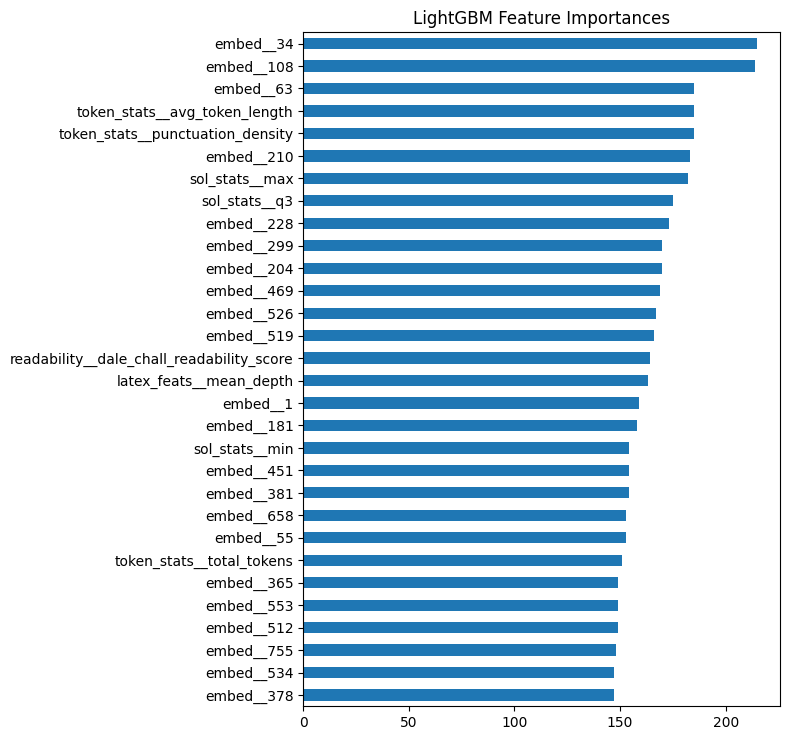

In [ ]:
importances=pipeline.named_steps["regressor"].feature_importances_
fi = pd.Series(importances, index=feat_names)


top_n = 30
top = fi.sort_values(ascending=False).head(top_n)

plt.figure(figsize=(8, top_n*0.25))
top[::-1].plot.barh()
plt.title("LightGBM Feature Importances")
plt.tight_layout()
plt.show()

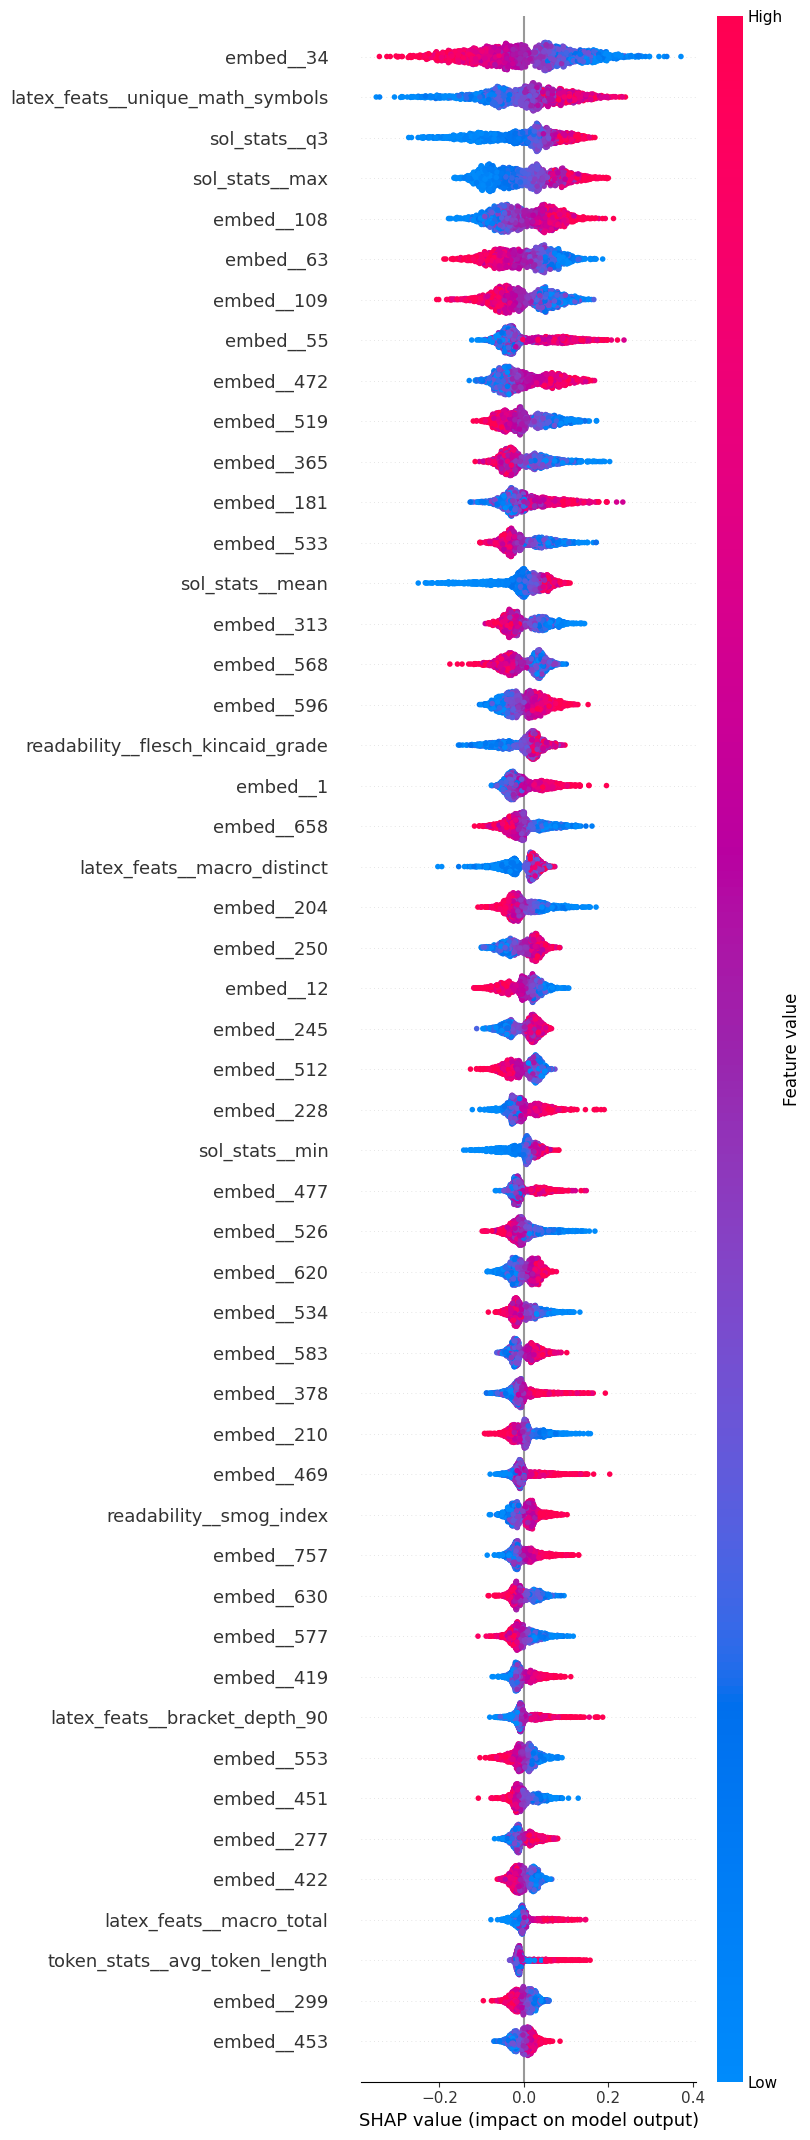

In [ ]:

lgbm = pipeline.named_steps["regressor"]
pre  = pipeline.named_steps["features"]


X_bg = X_train_reg.sample(8000, random_state=0)
X_bg_trans = pre.transform(X_bg)

if spa.issparse(X_bg_trans):
    X_for_shap = X_bg_trans.toarray()
else:
    X_for_shap = X_bg_trans

explainer = shap.TreeExplainer(lgbm)


X_ex = X_test_reg.sample(2000, random_state=1)
X_ex_trans = pre.transform(X_ex)
if spa.issparse(X_ex_trans):
    X_for_shap_test = X_ex_trans.toarray()
else:
    X_for_shap_test = X_ex_trans
shap_values = explainer.shap_values(X_for_shap_test)

shap.summary_plot(
    shap_values,
    X_for_shap_test,
    feature_names=feat_names,
    max_display=50,
)

**Feature Importance vs. SHAP Insights**

- **Embeddings lead the pack.**  
  Both LightGBM’s built-in gains and the SHAP summary agree that a small handful of SBERT embedding dimensions (e.g. `embed__34`, `embed__108`, `embed__63`) drive most of the predictive power.  

- **Solution-length stats are very strong.**  
  The max, mean and 75 th percentile of our R1/R2/R3 “solution lengths” rank near the top in both plots—confirming that longer worked‐out solutions tend to correlate with higher difficulty.  

- **Math-specific features punch above their weight.**  
  SHAP highlights `latex_feats__unique_math_symbols` as one of the very top contributors, even though its raw gain ranking was lower. This tells us symbol‐rich questions are often harder.

- **Token counts and readability are overrated.**  
  Although LightGBM sometimes splits on `total_tokens` or Flesch/Dale-Chall scores (they appear in the gain list), their overall SHAP magnitudes are small. In practice, they explain little variation once embeddings and solution stats are included.

- **Discrepancies reveal “shortcuts.”**  
  The model can leverage simple heuristics (e.g. question length) to boost gain, but SHAP shows these have inconsistent, marginal effects. Relying on them may hurt generalization.

---

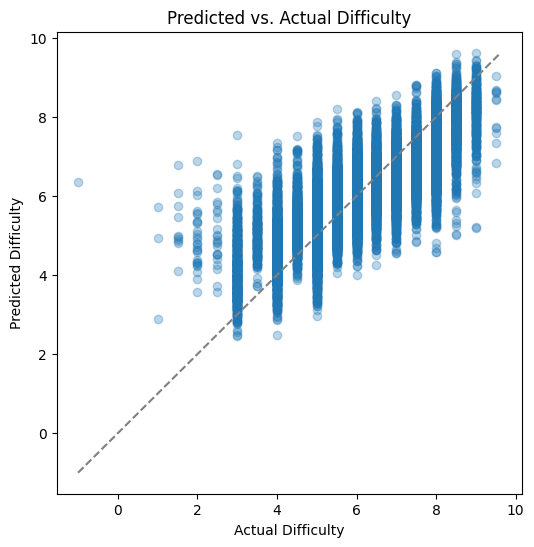

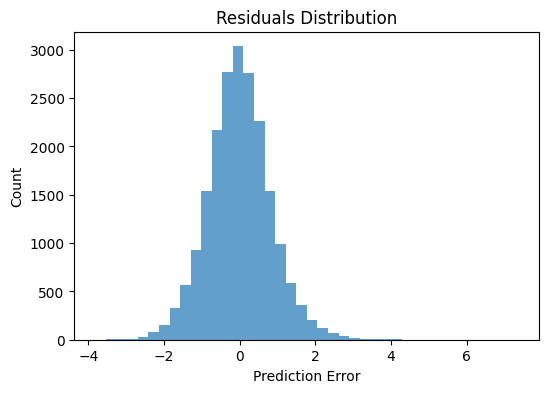

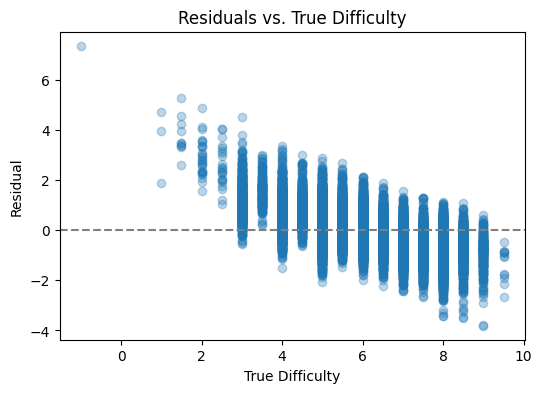

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test_reg, y_pred, alpha=0.3)
lims = [min(y_test_reg.min(), y_pred.min()), max(y_test_reg.max(), y_pred.max())]
plt.plot(lims, lims, "--", color="gray")
plt.xlabel("Actual Difficulty"); plt.ylabel("Predicted Difficulty")
plt.title("Predicted vs. Actual Difficulty")
plt.show()

y_true=y_test_reg
plt.figure(figsize=(6,4))
plt.hist((y_pred - y_true), bins=40, alpha=0.7)
plt.title("Residuals Distribution"); plt.xlabel("Prediction Error"); plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(y_true, (y_pred - y_true), alpha=0.3)
plt.axhline(0, color="gray", linestyle="--")
plt.xlabel("True Difficulty"); plt.ylabel("Residual")
plt.title("Residuals vs. True Difficulty")
plt.show()


**Predicted vs. Actual Difficulty**  
- ✔️ The points cluster tightly along the 45° reference line, showing the model captures the overall trend well.  
- ✔️ Most predictions fall within ±1 of the true label, indicating good mean accuracy.  
- ⚠️ You can see “bands” at integer difficulty levels (a side‐effect of training on discrete labels).  
- ⚠️ There’s a slight bias: at the low end (actual < 3) the model tends to overestimate, and at the high end (>8) it tends to underestimate.  

**Residuals Distribution**  
- ✔️ The residuals form an approximately symmetric, bell‐shaped histogram centered near zero—evidence that the errors are unbiased on average.  
- ⚠️ The tails extend out to ±4, signaling occasional large miss‐predictions (possible outliers or rare question types).  
- ⚠️ A slight skew toward positive residuals suggests a mild tendency to over-predict, especially on easier questions.  

**Residuals vs. True Difficulty**  
- ✔️ In the mid‐range difficulties (≈4–6), residuals are tightly packed around zero, showing high precision on the bulk of the data.  
- ⚠️ There’s a clear heteroscedastic pattern: positive residuals (over-predictions) for low‐difficulty questions and negative residuals (under-predictions) for high‐difficulty ones.  
- ⚠️ This “compression” means the model’s slope is too shallow—it doesn’t fully stretch out the extremes.  


**TODO: add non-linear and interactions features to overcome the problems emerged from the previous plots**

## M1S: Base model (short answer)

## M2: Introduce reasoning

## Comparisons